# Project 7: Implémentation d’un modèle de scoring
## Notebook - Prétraitement et modélisation des données 

## Index 
<ol>
    <li><a href="#intro">Introduction</a></li>
    <li><a href="#load">Importation des packets et données</a></li>
    <li><a href="#EDA">Exploration et prétraitement des données</a>
        <ol>
            <li><a href="#merge">Combinaison des datasets et création de variables</a></li> 
            <li><a href="#feat_select">Sélection des variables - réduction dimensionnelle</a></li> 
        </ol>
    </li>    
    <li><a href="#model">Modélisation</a>
        <ol>
            <li><a href="#reg">Régression logistique</a></li>
            <li><a href="#rf">Random Forest</a></li>
            <li><a href="#gbm">Gradiant Boosting</a></li>
        </ol>
    </li>    
    <li><a href="#interp">Interprétabilité du modèle final</a></li>
</ol>





<a id='intro'></a>
## 1. Introduction 

L'objectif de ce projet est de développer un modèle de scoring selon la probabilité de défaut de paiement d'un client, pour aider une société de crédit de consommation dans leur décision d'octroi de prêts. 

Ce 1er notebook est dedié à l'analyse, prétraitement et modélisation des données. Le modèle final sera implementaté sous forme d'API web avec Dash (dashboard du modèle) et deployé sur la platforme Heroku.

Le modèle sera développé à partir des données variés sur les clients (ex. socio-démographiques, historique de demandes de prêt, etc), disponilbes sur [Kaggle](https://www.kaggle.com/c/home-credit-default-risk/data). Il s'agit d'un problème de classification supervisée binaire, car on dispose des 2 classes annotées comme _target_: 0 (clients sans défaut de paiement) et 1 (clients en défaut). Cependant, on s'interesse à prédire la probabilité associée à la classification d'un client **comme défaut (1) - prob. de défaut paiement** ou pas défaut (0), et non à la classe en elle-même en sortie. Pour ce faire, on utilise la méthode `predict.proba`, lors de l'application du modèle entraîné pour la prédiction. L'évaluation du modèle sera faite è travers d'une métrique adaptée, comme l'AUC-ROC (exactitude n'est pas adaptée dans ce cas, d'autant moins que le _target_ présente des classes desiquilibrées). 

Le diagramme ci-dessous montre la structure relationnelle des données:
<!-- ![](data/home_credit_data.png) -->
<p align="center">
    <img src="data/home_credit_data.png" width="800">   
</p>

<a id='load'></a>
## 2. Importation des packets et données

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  

# featuretools for automated feature engineering (https://featuretools.alteryx.com/en/stable/install.html)
# conda install -c conda-forge featuretools
# !pip install featuretools
# import featuretools as ft

# general pre-processing pipeline
# from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.compose import make_column_transformer 
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold

# models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve, fbeta_score, confusion_matrix, classification_report


# Others
import gc
import time
import warnings
warnings.filterwarnings('ignore')

# specific functions for these project
from P7_functions import *

In [2]:
from contextlib import contextmanager

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

In [3]:
# List files available
print(os.listdir('data/input'))
csv_files=[f for f in os.listdir('data/input/') if '.csv' in f]

['application_test.csv', 'application_train.csv', 'bureau.csv', 'bureau_balance.csv', 'credit_card_balance.csv', 'HomeCredit_columns_description.csv', 'home_credit_data.png', 'installments_payments.csv', 'POS_CASH_balance.csv', 'previous_application.csv', 'sample_submission.csv']


In [4]:
csv_files=[f for f in os.listdir('data/input/') if '.csv' in f]
csv_files.remove('HomeCredit_columns_description.csv')
csv_files.remove('sample_submission.csv')
csv_files

['application_test.csv',
 'application_train.csv',
 'bureau.csv',
 'bureau_balance.csv',
 'credit_card_balance.csv',
 'installments_payments.csv',
 'POS_CASH_balance.csv',
 'previous_application.csv']

In [5]:
# read and put all DFs in a dict
key_names = ['test','train','bureau','balance','ccard','install_pay','pos_cash_bal','prev_app']
dict_df = {}
for k, file in zip(key_names, csv_files):
    print(k, file)
    dict_df[k]=pd.read_csv('data/input/'+ str(file))  #uint-8 error in HomeCredit_columns_description.csv

test application_test.csv
train application_train.csv
bureau bureau.csv
balance bureau_balance.csv
ccard credit_card_balance.csv
install_pay installments_payments.csv
pos_cash_bal POS_CASH_balance.csv
prev_app previous_application.csv


In [7]:
data_desc = pd.read_csv('data/input/HomeCredit_columns_description.csv', encoding = 'ISO-8859-1')

In [8]:
data_desc.Description.tolist()[:5]

['ID of loan in our sample',
 'Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)',
 'Identification if loan is cash or revolving',
 'Gender of the client',
 'Flag if the client owns a car']

In [9]:
# reduce memory usage by using more efficient types for the variables (ex. category is better than object if nb categories ~ nb df rows)
# for k, df in dict_df.items():
#     print(k)
#     dict_df[k] = convert_types(df, print_info=True)

<a id='EDA'></a>
## 3. Exploration et prétraitement 

In [10]:
for k, df in dict_df.items():
    print('{}: {}'.format(k, df.shape))

test: (48744, 121)
train: (307511, 122)
bureau: (1716428, 17)
balance: (27299925, 3)
ccard: (3840312, 23)
install_pay: (13605401, 8)
pos_cash_bal: (10001358, 8)
prev_app: (1670214, 37)


In [11]:
print('Training and testing data shapes: ', dict_df['train'].shape, dict_df['test'].shape)
print('proportion of testing set:', dict_df['test'].shape[0]/(dict_df['test'].shape[0]+dict_df['train'].shape[0]))

Training and testing data shapes:  (307511, 122) (48744, 121)
proportion of testing set: 0.13682334283027606


In [12]:
# Data types etc.
display(dict_df['train'].info())
dict_df['test'].dtypes.value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


None

float64    65
int64      40
object     16
dtype: int64

**Valeurs manquantes, doubles et uniques:**

In [13]:
miss_values_percent=[]
cols_with_nan=[]
for k, df in dict_df.items():
    miss_values_percent.append(round(df.isna().sum().sum()/len(df),2))
    miss_by_col = df.isnull().sum()
    cols_with_nan.append(len(miss_by_col.loc[miss_by_col!=0]))
    print('\n{} \n% of total NaN: {:.2f} \nNr of entire double rows: {:}'.format(k,
                                                                               round(df.isna().sum().sum()/len(df),2), 
                                                                               df.duplicated().sum()))
    display(df.describe())


test 
% of total NaN: 28.81 
Nr of entire double rows: 0


,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,48744.000000,48744.000000,4.874400e+04,4.874400e+04,48720.000000,4.874400e+04,48744.000000,48744.000000,48744.000000,48744.000000,...,48744.000000,48744.0,48744.0,48744.0,42695.000000,42695.000000,42695.000000,42695.000000,42695.000000,42695.000000
mean,277796.676350,0.397054,1.784318e+05,5.167404e+05,29426.240209,4.626188e+05,0.021226,-16068.084605,67485.366322,-4967.652716,...,0.001559,0.0,0.0,0.0,0.002108,0.001803,0.002787,0.009299,0.546902,1.983769
std,103169.547296,0.709047,1.015226e+05,3.653970e+05,16016.368315,3.367102e+05,0.014428,4325.900393,144348.507136,3552.612035,...,0.039456,0.0,0.0,0.0,0.046373,0.046132,0.054037,0.110924,0.693305,1.838873
min,100001.000000,0.000000,2.694150e+04,4.500000e+04,2295.000000,4.500000e+04,0.000253,-25195.000000,-17463.000000,-23722.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,188557.750000,0.000000,1.125000e+05,2.606400e+05,17973.000000,2.250000e+05,0.010006,-19637.000000,-2910.000000,-7459.250000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,277549.000000,0.000000,1.575000e+05,4.500000e+05,26199.000000,3.960000e+05,0.018850,-15785.000000,-1293.000000,-4490.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,367555.500000,1.000000,2.250000e+05,6.750000e+05,37390.500000,6.300000e+05,0.028663,-12496.000000,-296.000000,-1901.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000
max,456250.000000,20.000000,4.410000e+06,2.245500e+06,180576.000000,2.245500e+06,0.072508,-7338.000000,365243.000000,0.000000,...,1.000000,0.0,0.0,0.0,2.000000,2.000000,2.000000,6.000000,7.000000,17.000000



train 
% of total NaN: 29.76 
Nr of entire double rows: 0


,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000



bureau 
% of total NaN: 2.30 
Nr of entire double rows: 0


,SK_ID_CURR,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
count,1.716428e+06,1.716428e+06,1.716428e+06,1.716428e+06,1.610875e+06,1.082775e+06,5.919400e+05,1.716428e+06,1.716415e+06,1.458759e+06,1.124648e+06,1.716428e+06,1.716428e+06,4.896370e+05
mean,2.782149e+05,5.924434e+06,-1.142108e+03,8.181666e-01,5.105174e+02,-1.017437e+03,3.825418e+03,6.410406e-03,3.549946e+05,1.370851e+05,6.229515e+03,3.791276e+01,-5.937483e+02,1.571276e+04
std,1.029386e+05,5.322657e+05,7.951649e+02,3.654443e+01,4.994220e+03,7.140106e+02,2.060316e+05,9.622391e-02,1.149811e+06,6.774011e+05,4.503203e+04,5.937650e+03,7.207473e+02,3.258269e+05
min,1.000010e+05,5.000000e+06,-2.922000e+03,0.000000e+00,-4.206000e+04,-4.202300e+04,0.000000e+00,0.000000e+00,0.000000e+00,-4.705600e+06,-5.864061e+05,0.000000e+00,-4.194700e+04,0.000000e+00
25%,1.888668e+05,5.463954e+06,-1.666000e+03,0.000000e+00,-1.138000e+03,-1.489000e+03,0.000000e+00,0.000000e+00,5.130000e+04,0.000000e+00,0.000000e+00,0.000000e+00,-9.080000e+02,0.000000e+00
50%,2.780550e+05,5.926304e+06,-9.870000e+02,0.000000e+00,-3.300000e+02,-8.970000e+02,0.000000e+00,0.000000e+00,1.255185e+05,0.000000e+00,0.000000e+00,0.000000e+00,-3.950000e+02,0.000000e+00
75%,3.674260e+05,6.385681e+06,-4.740000e+02,0.000000e+00,4.740000e+02,-4.250000e+02,0.000000e+00,0.000000e+00,3.150000e+05,4.015350e+04,0.000000e+00,0.000000e+00,-3.300000e+01,1.350000e+04
max,4.562550e+05,6.843457e+06,0.000000e+00,2.792000e+03,3.119900e+04,0.000000e+00,1.159872e+08,9.000000e+00,5.850000e+08,1.701000e+08,4.705600e+06,3.756681e+06,3.720000e+02,1.184534e+08



balance 
% of total NaN: 0.00 
Nr of entire double rows: 0


,SK_ID_BUREAU,MONTHS_BALANCE
count,2.729992e+07,2.729992e+07
mean,6.036297e+06,-3.074169e+01
std,4.923489e+05,2.386451e+01
min,5.001709e+06,-9.600000e+01
25%,5.730933e+06,-4.600000e+01
50%,6.070821e+06,-2.500000e+01
75%,6.431951e+06,-1.100000e+01
max,6.842888e+06,0.000000e+00



ccard 
% of total NaN: 1.53 
Nr of entire double rows: 0


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,SK_DPD,SK_DPD_DEF
count,3.840312e+06,3.840312e+06,3.840312e+06,3.840312e+06,3.840312e+06,3.090496e+06,3.840312e+06,3.090496e+06,3.090496e+06,3.535076e+06,...,3.840312e+06,3.840312e+06,3.840312e+06,3.090496e+06,3.840312e+06,3.090496e+06,3.090496e+06,3.535076e+06,3.840312e+06,3.840312e+06
mean,1.904504e+06,2.783242e+05,-3.452192e+01,5.830016e+04,1.538080e+05,5.961325e+03,7.433388e+03,2.881696e+02,2.968805e+03,3.540204e+03,...,5.596588e+04,5.808881e+04,5.809829e+04,3.094490e-01,7.031439e-01,4.812496e-03,5.594791e-01,2.082508e+01,9.283667e+00,3.316220e-01
std,5.364695e+05,1.027045e+05,2.666775e+01,1.063070e+05,1.651457e+05,2.822569e+04,3.384608e+04,8.201989e+03,2.079689e+04,5.600154e+03,...,1.025336e+05,1.059654e+05,1.059718e+05,1.100401e+00,3.190347e+00,8.263861e-02,3.240649e+00,2.005149e+01,9.751570e+01,2.147923e+01
min,1.000018e+06,1.000060e+05,-9.600000e+01,-4.202502e+05,0.000000e+00,-6.827310e+03,-6.211620e+03,0.000000e+00,0.000000e+00,0.000000e+00,...,-4.233058e+05,-4.202502e+05,-4.202502e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.434385e+06,1.895170e+05,-5.500000e+01,0.000000e+00,4.500000e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00
50%,1.897122e+06,2.783960e+05,-2.800000e+01,0.000000e+00,1.125000e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.500000e+01,0.000000e+00,0.000000e+00
75%,2.369328e+06,3.675800e+05,-1.100000e+01,8.904669e+04,1.800000e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.633911e+03,...,8.535924e+04,8.889949e+04,8.891451e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.200000e+01,0.000000e+00,0.000000e+00
max,2.843496e+06,4.562500e+05,-1.000000e+00,1.505902e+06,1.350000e+06,2.115000e+06,2.287098e+06,1.529847e+06,2.239274e+06,2.028820e+05,...,1.472317e+06,1.493338e+06,1.493338e+06,5.100000e+01,1.650000e+02,1.200000e+01,1.650000e+02,1.200000e+02,3.260000e+03,3.260000e+03



install_pay 
% of total NaN: 0.00 
Nr of entire double rows: 0


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
count,1.360540e+07,1.360540e+07,1.360540e+07,1.360540e+07,1.360540e+07,1.360250e+07,1.360540e+07,1.360250e+07
mean,1.903365e+06,2.784449e+05,8.566373e-01,1.887090e+01,-1.042270e+03,-1.051114e+03,1.705091e+04,1.723822e+04
std,5.362029e+05,1.027183e+05,1.035216e+00,2.666407e+01,8.009463e+02,8.005859e+02,5.057025e+04,5.473578e+04
min,1.000001e+06,1.000010e+05,0.000000e+00,1.000000e+00,-2.922000e+03,-4.921000e+03,0.000000e+00,0.000000e+00
25%,1.434191e+06,1.896390e+05,0.000000e+00,4.000000e+00,-1.654000e+03,-1.662000e+03,4.226085e+03,3.398265e+03
50%,1.896520e+06,2.786850e+05,1.000000e+00,8.000000e+00,-8.180000e+02,-8.270000e+02,8.884080e+03,8.125515e+03
75%,2.369094e+06,3.675300e+05,1.000000e+00,1.900000e+01,-3.610000e+02,-3.700000e+02,1.671021e+04,1.610842e+04
max,2.843499e+06,4.562550e+05,1.780000e+02,2.770000e+02,-1.000000e+00,-1.000000e+00,3.771488e+06,3.771488e+06



pos_cash_bal 
% of total NaN: 0.01 
Nr of entire double rows: 0


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,SK_DPD,SK_DPD_DEF
count,1.000136e+07,1.000136e+07,1.000136e+07,9.975287e+06,9.975271e+06,1.000136e+07,1.000136e+07
mean,1.903217e+06,2.784039e+05,-3.501259e+01,1.708965e+01,1.048384e+01,1.160693e+01,6.544684e-01
std,5.358465e+05,1.027637e+05,2.606657e+01,1.199506e+01,1.110906e+01,1.327140e+02,3.276249e+01
min,1.000001e+06,1.000010e+05,-9.600000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.434405e+06,1.895500e+05,-5.400000e+01,1.000000e+01,3.000000e+00,0.000000e+00,0.000000e+00
50%,1.896565e+06,2.786540e+05,-2.800000e+01,1.200000e+01,7.000000e+00,0.000000e+00,0.000000e+00
75%,2.368963e+06,3.674290e+05,-1.300000e+01,2.400000e+01,1.400000e+01,0.000000e+00,0.000000e+00
max,2.843499e+06,4.562550e+05,-1.000000e+00,9.200000e+01,8.500000e+01,4.231000e+03,3.595000e+03



prev_app 
% of total NaN: 6.65 
Nr of entire double rows: 0


,SK_ID_PREV,SK_ID_CURR,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,HOUR_APPR_PROCESS_START,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,...,RATE_INTEREST_PRIVILEGED,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
count,1.670214e+06,1.670214e+06,1.297979e+06,1.670214e+06,1.670213e+06,7.743700e+05,1.284699e+06,1.670214e+06,1.670214e+06,774370.000000,...,5951.000000,1.670214e+06,1.670214e+06,1.297984e+06,997149.000000,997149.000000,997149.000000,997149.000000,997149.000000,997149.000000
mean,1.923089e+06,2.783572e+05,1.595512e+04,1.752339e+05,1.961140e+05,6.697402e+03,2.278473e+05,1.248418e+01,9.964675e-01,0.079637,...,0.773503,-8.806797e+02,3.139511e+02,1.605408e+01,342209.855039,13826.269337,33767.774054,76582.403064,81992.343838,0.332570
std,5.325980e+05,1.028148e+05,1.478214e+04,2.927798e+05,3.185746e+05,2.092150e+04,3.153966e+05,3.334028e+00,5.932963e-02,0.107823,...,0.100879,7.790997e+02,7.127443e+03,1.456729e+01,88916.115833,72444.869708,106857.034789,149647.415123,153303.516729,0.471134
min,1.000001e+06,1.000010e+05,0.000000e+00,0.000000e+00,0.000000e+00,-9.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,-0.000015,...,0.373150,-2.922000e+03,-1.000000e+00,0.000000e+00,-2922.000000,-2892.000000,-2801.000000,-2889.000000,-2874.000000,0.000000
25%,1.461857e+06,1.893290e+05,6.321780e+03,1.872000e+04,2.416050e+04,0.000000e+00,5.084100e+04,1.000000e+01,1.000000e+00,0.000000,...,0.715645,-1.300000e+03,-1.000000e+00,6.000000e+00,365243.000000,-1628.000000,-1242.000000,-1314.000000,-1270.000000,0.000000
50%,1.923110e+06,2.787145e+05,1.125000e+04,7.104600e+04,8.054100e+04,1.638000e+03,1.123200e+05,1.200000e+01,1.000000e+00,0.051605,...,0.835095,-5.810000e+02,3.000000e+00,1.200000e+01,365243.000000,-831.000000,-361.000000,-537.000000,-499.000000,0.000000
75%,2.384280e+06,3.675140e+05,2.065842e+04,1.803600e+05,2.164185e+05,7.740000e+03,2.340000e+05,1.500000e+01,1.000000e+00,0.108909,...,0.852537,-2.800000e+02,8.200000e+01,2.400000e+01,365243.000000,-411.000000,129.000000,-74.000000,-44.000000,1.000000
max,2.845382e+06,4.562550e+05,4.180581e+05,6.905160e+06,6.905160e+06,3.060045e+06,6.905160e+06,2.300000e+01,1.000000e+00,1.000000,...,1.000000,-1.000000e+00,4.000000e+06,8.400000e+01,365243.000000,365243.000000,365243.000000,365243.000000,365243.000000,1.000000


In [14]:
for k, df in dict_df.items():
    # Number of unique classes in each categorical column 
    print('\n',k, '\n',df.select_dtypes('object').apply(pd.Series.nunique, axis = 0))


 test 
 NAME_CONTRACT_TYPE             2
CODE_GENDER                    2
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               7
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             5
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

 train 
 NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_M

In [15]:
dict_df['train']['SK_ID_CURR'].is_unique

True

In [16]:
miss_values_percent, cols_with_nan

([28.81, 29.76, 2.3, 0.0, 1.53, 0.0, 0.01, 6.65], [64, 67, 7, 0, 9, 2, 2, 16])

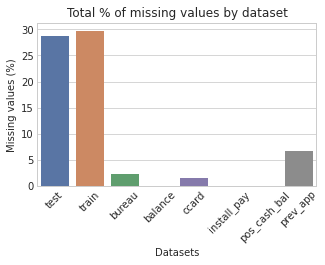

In [17]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(5,3))
    sns.barplot(x=list(dict_df.keys()), y=miss_values_percent, palette='deep')
    plt.xticks(rotation=45)
    plt.ylabel('Missing values (%)'), plt.xlabel('Datasets')
    plt.title('Total % of missing values by dataset')

In [18]:
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    print(len(total.loc[total!=0]), 'columns with missing values out of', data.shape[1])
    
    return pd.concat([total, percent], axis=1, keys=['Total_missing', 'Percentage'])

In [19]:
mis_values = missing_data(dict_df['train'])

67 columns with missing values out of 122


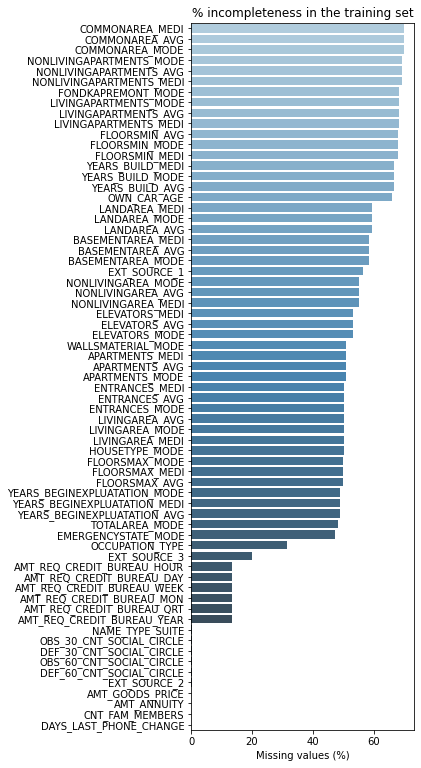

In [20]:
plt.figure(figsize=(4,13))
sns.barplot(y=mis_values.loc[mis_values['Percentage']!=0].index, x=mis_values.loc[mis_values['Total_missing']!=0]['Percentage'].values, palette='Blues_d')
_=plt.xlabel('Missing values (%)'), plt.title('% incompleteness in the training set')

In [21]:
missing_data(dict_df['test'])

64 columns with missing values out of 121


,Total_missing,Percentage
COMMONAREA_AVG,33495,68.716150
COMMONAREA_MODE,33495,68.716150
COMMONAREA_MEDI,33495,68.716150
NONLIVINGAPARTMENTS_AVG,33347,68.412523
NONLIVINGAPARTMENTS_MODE,33347,68.412523
...,...,...
NAME_HOUSING_TYPE,0,0.000000
NAME_FAMILY_STATUS,0,0.000000
NAME_EDUCATION_TYPE,0,0.000000
NAME_INCOME_TYPE,0,0.000000


In [22]:
# missing values by column in each df
df_missing = pd.DataFrame()
for k, df in dict_df.items():
    df_missing = pd.concat([df_missing, missing_data(df)['Percentage'].to_frame(name=k)],axis=1)

64 columns with missing values out of 121
67 columns with missing values out of 122
7 columns with missing values out of 17
0 columns with missing values out of 3
9 columns with missing values out of 23
2 columns with missing values out of 8
2 columns with missing values out of 8
16 columns with missing values out of 37


In [23]:
# rearrange the ratio of missing values in each columns
df_missing = df_missing.T.stack().reset_index()
df_missing.columns = ['df', 'column', 'missing_percent']
df_missing.head(3)

,df,column,missing_percent
0,test,COMMONAREA_AVG,68.71615
1,test,COMMONAREA_MODE,68.71615
2,test,COMMONAREA_MEDI,68.71615


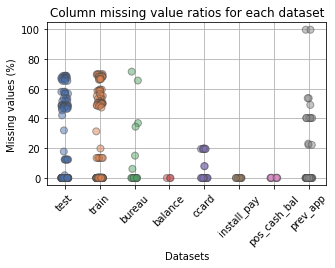

In [24]:
plt.figure(figsize=(5,3))
sns.stripplot(x='df', y='missing_percent', data=df_missing, linewidth=1, alpha = 0.5, size=7, palette='deep')
plt.xticks(rotation=45)
plt.ylabel('Missing values (%)'), plt.xlabel('Datasets')
plt.title('Column missing value ratios for each dataset')
plt.grid()

**Distribution de la variable _target_:**

0    0.92
1    0.08
Name: TARGET, dtype: float64


(<AxesSubplot:title={'center':'Target distribution'}, xlabel='TARGET', ylabel='Frenquency'>,
 Text(0.5, 1.0, 'Target distribution'),
 Text(0, 0.5, 'Frenquency'))

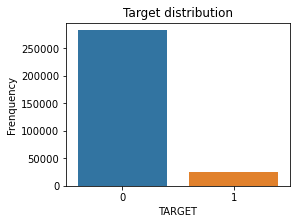

In [25]:
print(dict_df['train'].TARGET.value_counts(normalize=True).round(2))
plt.figure(figsize=(4,3))
sns.countplot(dict_df['train'].TARGET), plt.title('Target distribution'), plt.ylabel('Frenquency')

**Observations:**
- Train et test sets présentent 30% des valeurs manquantes sur la totalité des valeurs, reparties en plusieurs colonnes (> 50% colonnes présentent des valeurs manquantes dans les 2 jeux des données, dont la plupart plus de 40%).
- Plusieurs variables, comme _DAYS_BIRTH_ (âge du client en jours) et _DAYS_EMPLOYED_ présentent des valuers négatifs, car sont relatives au jour de la demande de prêt, passser à positives. La valeur max de _DAYS_EMPLOYED_ et autres variables _DAYS..._ en `prev_app` est positive et anormalement élevé (~1000 ans) - remplacer par nan.  
- Quelques variables catégorielles n'ont pas le même nb de valeurs (classes) uniques, et doivent être uniformisées (entre train et test sets au moins, voir d'autres stes si utiles). Plusieurs sont binaires (distributions binomiales).
-Les classes de la variable de sortie (TARGET) sont très desiquilibrées. On pourrait utiliser un algorithme pour _oversampling-downsampling_ chaque classe de maniere plus robuste (ex. SOMTE pour creation de nouvelles observations sans répetition, avec neighbors...), car un simple oversampling avec répetition des observations de la classe 1 peut conduire facilement à overfitting. Ou bien utiliser des métriques adaptés au problème pour l'evaluation du modèle.

In [26]:
data_desc.loc[data_desc['Row'].isin(['DAYS_BIRTH','DAYS_EMPLOYED'])]['Description'].tolist()

["Client's age in days at the time of application",
 'How many days before the application the person started current employment']

<a id='merge'></a>
### A. Combinaison des dataframes et création de variables

In [27]:
# Aggregations in dataframes before merging
def agg_variables(df, df_name, group_var, cat='count'):
    '''Aggregates variables in df along group_var (ID)
    to prepare them before merging'''
    
    # Remove id variables other than grouping variable
    for col in df:
        if col != group_var and 'SK_ID' in col:
            df = df.drop(columns = col)
            
    original_columns = list(df.columns)
    numerical_columns = df.select_dtypes(exclude='object').columns
    categorical_columns = df.select_dtypes('object').columns
    
    # agg dict for categorical features
    if cat=='mode':  
        cat_aggregations = {}
        for col in categorical_columns:
            cat_aggregations[col] = lambda x: x.mode()[0]  #mode of each categotical variable    
    else:      
        # One-hot encoding for categorical columns with get_dummies
        df = pd.get_dummies(df, columns= categorical_columns)
        new_columns = [c for c in df.columns if c not in original_columns]
        cat_aggregations = {}
        for cat in new_columns:
            cat_aggregations[cat] = ['mean']  #relative freq of each class in each categorical var
    
    # agg dict for numeric features
    num_aggregations = {}
    for col in numerical_columns:
        num_aggregations[col] = ['median']
    
    df_agg = df.groupby(group_var).agg({**num_aggregations, **cat_aggregations})
    df_agg.drop(group_var, axis=1, inplace=True)
    df_agg.columns = pd.Index([df_name + '_' + e[0] + '_' + e[1] for e in df_agg.columns.tolist()])
    del df
    gc.collect() #to free memory
    return df_agg

In [28]:
ID_train=dict_df['train'].SK_ID_CURR
ID_test=dict_df['test'].SK_ID_CURR

data = dict_df['train'].append(dict_df['test'])
data.shape

(356255, 122)

**Données sur prêts anterieurs dans d'autres institutions**
> Combiner `balance` avec `bureau` et ensuite merger avec `data` par `SK_ID_CURR`.

In [29]:
dict_df['bureau'].columns, dict_df['balance'].columns

(Index(['SK_ID_CURR', 'SK_ID_BUREAU', 'CREDIT_ACTIVE', 'CREDIT_CURRENCY',
        'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE',
        'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG',
        'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT',
        'AMT_CREDIT_SUM_OVERDUE', 'CREDIT_TYPE', 'DAYS_CREDIT_UPDATE',
        'AMT_ANNUITY'],
       dtype='object'),
 Index(['SK_ID_BUREAU', 'MONTHS_BALANCE', 'STATUS'], dtype='object'))

In [30]:
# ex of 1 previous loan details
dict_df['balance'].loc[dict_df['balance']['SK_ID_BUREAU']==5715449]

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
27,5715449,0,C
28,5715449,-1,C
29,5715449,-2,C
30,5715449,-3,C
31,5715449,-4,C
32,5715449,-5,C
33,5715449,-6,0
34,5715449,-7,0
35,5715449,-8,0
36,5715449,-9,0


In [31]:
df_balance = dict_df['balance'].copy()
df_balance['MONTHS_BALANCE_last'] = df_balance.groupby('SK_ID_BUREAU')['MONTHS_BALANCE'].transform('max') #value of last month (max case negative count)
df_balance['MONTHS_BALANCE_count'] = df_balance.groupby('SK_ID_BUREAU')['MONTHS_BALANCE'].transform('count') 

# Keep only last month_balance  
# df_balance.drop_duplicates('SK_ID_BUREAU', keep='first', inplace=True) # if they're not ordered better to do as below
index=np.where(df_balance['MONTHS_BALANCE']==df_balance['MONTHS_BALANCE_last'])
df_balance=df_balance.loc[index]

# pass to positive months 
df_balance.drop(['MONTHS_BALANCE'], axis=1, inplace=True)
df_balance['MONTHS_BALANCE_last'] = np.abs(df_balance.MONTHS_BALANCE_last)

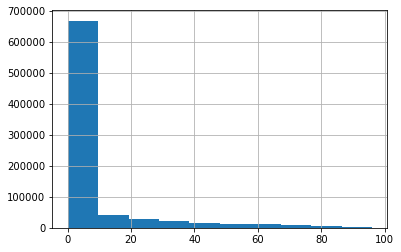

(<AxesSubplot:xlabel='STATUS', ylabel='count'>, None)

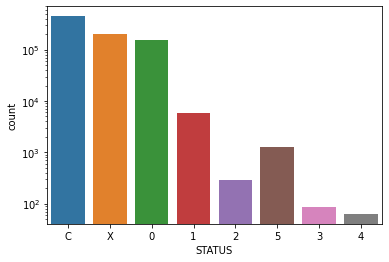

In [32]:
df_balance.MONTHS_BALANCE_last.hist()
plt.show()
sns.countplot(df_balance.STATUS), plt.yscale('log')

La plupart des prêts anterieurs sont en état fermé (C) ou inconnu (X) pour le dernier mois (ce mois va répresenter des prêts encore récents), tandis que des valuers du dernier mois de paiement plus elevées representeront des prêts plus anciens.

In [33]:
# merging bureau_balance with bureau
dict_df['bureau'] = dict_df['bureau'].merge(df_balance, how='left', on='SK_ID_BUREAU')
del df_balance
dict_df['bureau'].columns

Index(['SK_ID_CURR', 'SK_ID_BUREAU', 'CREDIT_ACTIVE', 'CREDIT_CURRENCY',
       'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE',
       'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG',
       'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT',
       'AMT_CREDIT_SUM_OVERDUE', 'CREDIT_TYPE', 'DAYS_CREDIT_UPDATE',
       'AMT_ANNUITY', 'STATUS', 'MONTHS_BALANCE_last', 'MONTHS_BALANCE_count'],
      dtype='object')

In [34]:
#Aggregate previous loans data by current loan ID (SK_ID_CURR) - 1 by client 
with timer("Process bureau"):
        bureau_agg = agg_variables(dict_df['bureau'], group_var = 'SK_ID_CURR', df_name = 'bureau')
#         bureau_agg = agg_variables(dict_df['bureau'], group_var = 'SK_ID_CURR', df_name = 'bureau', cat='mode')
        # Add variable nb_previous_loans
        bureau_agg['bureau_PREV_LOANS_count'] = dict_df['bureau'].groupby('SK_ID_CURR')['SK_ID_BUREAU'].count()
        print('bureau_agg df shape:', bureau_agg.shape)
        data =  data.merge(bureau_agg, right_index = True, left_on = 'SK_ID_CURR', how = 'outer') #data.join(bureau_agg, how='left', on='SK_ID_CURR')
        del bureau_agg
        gc.collect()

bureau_agg df shape: (305811, 46)
Process bureau - done in 9s


In [35]:
data.shape[1]

168

**Données sur prêts anterieurs chez Home Credit**
> Combiner `prev_app`, `pos_cash_bal`, `install_pay` et `ccard` avec `data` par `SK_ID_CURR`.
>- `pos_cash_bal`: on prend les valeurs correspondantes au dernier mois paiement (variable dernier mois peut diferencier entre prêts + et - récents, mais peut-être pas très utile. On creer aussi nb de mois de paiement. SK_DPD (_days past due_) agrégée par mediane des mois. Ces variables sont ensuite agregées par la mediane des prêts anterieurs et freq_relative de chaque categorie pour le ID du prêt en cours.

In [36]:
# _=dict_df['prev_app'].select_dtypes(exclude='object').hist(figsize=(10,8))
dict_df['prev_app'].columns

Index(['SK_ID_PREV', 'SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'AMT_ANNUITY',
       'AMT_APPLICATION', 'AMT_CREDIT', 'AMT_DOWN_PAYMENT', 'AMT_GOODS_PRICE',
       'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START',
       'FLAG_LAST_APPL_PER_CONTRACT', 'NFLAG_LAST_APPL_IN_DAY',
       'RATE_DOWN_PAYMENT', 'RATE_INTEREST_PRIMARY',
       'RATE_INTEREST_PRIVILEGED', 'NAME_CASH_LOAN_PURPOSE',
       'NAME_CONTRACT_STATUS', 'DAYS_DECISION', 'NAME_PAYMENT_TYPE',
       'CODE_REJECT_REASON', 'NAME_TYPE_SUITE', 'NAME_CLIENT_TYPE',
       'NAME_GOODS_CATEGORY', 'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE',
       'CHANNEL_TYPE', 'SELLERPLACE_AREA', 'NAME_SELLER_INDUSTRY',
       'CNT_PAYMENT', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION',
       'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION',
       'DAYS_LAST_DUE', 'DAYS_TERMINATION', 'NFLAG_INSURED_ON_APPROVAL'],
      dtype='object')

In [37]:
# # Preprocess previous_applications.csv

# # Days 365243 values -> nan
dict_df['prev_app']['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
dict_df['prev_app']['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
dict_df['prev_app']['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
dict_df['prev_app']['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
dict_df['prev_app']['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)

In [38]:
# drop some irrelevant/redundant columns 
dict_df['prev_app'].drop(['NFLAG_LAST_APPL_IN_DAY', 'NFLAG_INSURED_ON_APPROVAL',
                         'SELLERPLACE_AREA','DAYS_LAST_DUE_1ST_VERSION'], axis=1, inplace=True)

In [39]:
#Aggregate previous loans data by current loan ID (SK_ID_CURR) - 1 by client 
with timer("Process previous_applications"):
        prev_agg = agg_variables(dict_df['prev_app'], group_var = 'SK_ID_CURR', df_name = 'prevHC')
#         prev_agg = agg_variables(dict_df['prev_app'], group_var = 'SK_ID_CURR', df_name = 'prevHC', cat='mode')
        # Add variable nb_previous_loans_HC
        prev_agg['prevHC_PREV_LOANS_count'] = dict_df['prev_app'].groupby('SK_ID_CURR')['SK_ID_PREV'].count()
        print('prev_app_agg df shape:', prev_agg.shape)
        data =  data.merge(prev_agg, right_index = True, left_on = 'SK_ID_CURR', how = 'outer') 
        del prev_agg
        gc.collect()

prev_app_agg df shape: (338857, 159)
Process previous_applications - done in 26s


In [40]:
data.shape[1]

327

In [41]:
# index rate in common 
print(dict_df['prev_app']['SK_ID_PREV'].isin(dict_df['install_pay']['SK_ID_PREV']).sum()/len(dict_df['prev_app'])) 
print(dict_df['prev_app']['SK_ID_PREV'].isin(dict_df['pos_cash_bal']['SK_ID_PREV']).sum()/len(dict_df['prev_app'])) 
print(dict_df['prev_app']['SK_ID_PREV'].isin(dict_df['ccard']['SK_ID_PREV']).sum()/len(dict_df['prev_app']))

0.5741210407768106
0.5381963029887188
0.05564257035326012


In [42]:
dict_df['pos_cash_bal'].columns, dict_df['install_pay'].columns, dict_df['ccard'].columns

(Index(['SK_ID_PREV', 'SK_ID_CURR', 'MONTHS_BALANCE', 'CNT_INSTALMENT',
        'CNT_INSTALMENT_FUTURE', 'NAME_CONTRACT_STATUS', 'SK_DPD',
        'SK_DPD_DEF'],
       dtype='object'),
 Index(['SK_ID_PREV', 'SK_ID_CURR', 'NUM_INSTALMENT_VERSION',
        'NUM_INSTALMENT_NUMBER', 'DAYS_INSTALMENT', 'DAYS_ENTRY_PAYMENT',
        'AMT_INSTALMENT', 'AMT_PAYMENT'],
       dtype='object'),
 Index(['SK_ID_PREV', 'SK_ID_CURR', 'MONTHS_BALANCE', 'AMT_BALANCE',
        'AMT_CREDIT_LIMIT_ACTUAL', 'AMT_DRAWINGS_ATM_CURRENT',
        'AMT_DRAWINGS_CURRENT', 'AMT_DRAWINGS_OTHER_CURRENT',
        'AMT_DRAWINGS_POS_CURRENT', 'AMT_INST_MIN_REGULARITY',
        'AMT_PAYMENT_CURRENT', 'AMT_PAYMENT_TOTAL_CURRENT',
        'AMT_RECEIVABLE_PRINCIPAL', 'AMT_RECIVABLE', 'AMT_TOTAL_RECEIVABLE',
        'CNT_DRAWINGS_ATM_CURRENT', 'CNT_DRAWINGS_CURRENT',
        'CNT_DRAWINGS_OTHER_CURRENT', 'CNT_DRAWINGS_POS_CURRENT',
        'CNT_INSTALMENT_MATURE_CUM', 'NAME_CONTRACT_STATUS', 'SK_DPD',
        'SK_DPD_DEF']

In [43]:
print(dict_df['ccard']['NAME_CONTRACT_STATUS'].unique())
print(dict_df['pos_cash_bal']['NAME_CONTRACT_STATUS'].unique())

['Active' 'Completed' 'Demand' 'Signed' 'Sent proposal' 'Refused'
 'Approved']
['Active' 'Completed' 'Signed' 'Approved' 'Returned to the store' 'Demand'
 'Canceled' 'XNA' 'Amortized debt']


In [44]:
# align NAME_CONTRACT_STATUS in dfs
dict_df['pos_cash_bal']['NAME_CONTRACT_STATUS'].replace('XNA', np.nan, inplace=True)

In [45]:
df_pos = dict_df['pos_cash_bal'].copy()
df_pos['MONTHS_BALANCE_last'] =df_pos.groupby('SK_ID_PREV')['MONTHS_BALANCE'].transform('max') #value of last month (max case negative count)
df_pos['MONTHS_BALANCE_count'] = df_pos.groupby('SK_ID_PREV')['MONTHS_BALANCE'].transform('count') # nb of months_balance
df_pos['SK_DPD_median'] = df_pos.groupby('SK_ID_PREV')['SK_DPD'].transform('median') #median of delayed days by month

# Keep values for last month_balance  
index=np.where(df_pos['MONTHS_BALANCE']==df_pos['MONTHS_BALANCE_last'])
df_pos=df_pos.loc[index]
df_pos['MONTHS_BALANCE_last'] = np.abs(df_pos.MONTHS_BALANCE)

#rename the rest of cols '_last'
# df_pos.columns[3:6] = pd.Index([c + '_last' for c in df_pos.columns[3:6].tolist()])    
for c in df_pos.columns[3:6].tolist():
    df_pos.rename({c: c+'_last'} ,axis=1, inplace=True)
    
df_pos.drop(['MONTHS_BALANCE','SK_DPD','SK_DPD_DEF'], axis=1, inplace=True)
df_pos.columns

Index(['SK_ID_PREV', 'SK_ID_CURR', 'CNT_INSTALMENT_last',
       'CNT_INSTALMENT_FUTURE_last', 'NAME_CONTRACT_STATUS_last',
       'MONTHS_BALANCE_last', 'MONTHS_BALANCE_count', 'SK_DPD_median'],
      dtype='object')

In [46]:
#Aggregate pos_cash of prev loans by SK_ID_CURR and merge with data
with timer("Process pos_cash_balance"):
        pos_agg = agg_variables(df_pos, group_var = 'SK_ID_CURR', df_name = 'pos_')
        # Add variable nb_previous_loans in pos_cash
        pos_agg['pos_PREV_LOANS_count'] = df_pos.groupby('SK_ID_CURR')['SK_ID_PREV'].count()
        print('pos_agg df shape:', pos_agg.shape)
        data =  data.merge(pos_agg, right_index = True, left_on = 'SK_ID_CURR', how = 'outer') 
        del df_pos, pos_agg
        gc.collect()

pos_agg df shape: (337252, 14)
Process pos_cash_balance - done in 3s


In [47]:
data.shape[1]

341

In [48]:
# add  nb install/prev_loan to then aggregate by median 
dict_df['install_pay']['NUM_INSTALMENT_NUMBER_count'] = dict_df['install_pay'].groupby('SK_ID_PREV')['NUM_INSTALMENT_NUMBER'].transform('count') 
dict_df['install_pay'].drop(columns=['NUM_INSTALMENT_VERSION', 'NUM_INSTALMENT_NUMBER'], inplace=True)

#Aggregate installements_payments of prev loans by SK_ID_CURR and merge with data                                     
with timer("Process install_pay"):
        install_agg = agg_variables(dict_df['install_pay'], group_var = 'SK_ID_CURR', df_name = 'install_')
        # Add variable nb_previous_loans in install
        install_agg['install_PREV_LOANS_count'] = dict_df['install_pay'].groupby('SK_ID_CURR')['SK_ID_PREV'].count()
        print('install_agg df shape:', install_agg.shape)
        data =  data.merge(install_agg, right_index = True, left_on = 'SK_ID_CURR', how = 'outer')
        del install_agg
        gc.collect()

install_agg df shape: (339587, 6)
Process install_pay - done in 9s


In [49]:
data.shape[1]

347

In [50]:
# dict_df['ccard'].groupby('SK_ID_PREV').count()
dict_df['ccard'].loc[dict_df['ccard']['SK_ID_CURR']==394447]

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
277653,1000018,394447,-5,40934.070,45000,0.0,2335.500,0.0,2335.500,2250.00,...,40934.070,40934.070,0.0,2,0.0,2.0,1.0,Active,0,0
1375415,1000018,394447,-6,38879.145,45000,13500.0,51042.645,0.0,37542.645,0.00,...,37542.645,37542.645,3.0,15,0.0,12.0,0.0,Active,0,0
2159094,1000018,394447,-2,136695.420,135000,0.0,22827.330,0.0,22827.330,6206.67,...,136024.920,136024.920,0.0,11,0.0,11.0,4.0,Active,0,0
2192275,1000018,394447,-3,113862.285,135000,13500.0,69156.945,0.0,55656.945,2263.77,...,109150.785,109150.785,3.0,14,0.0,11.0,3.0,Active,0,0
2559582,1000018,394447,-4,44360.505,45000,0.0,2032.560,0.0,2032.560,2250.00,...,44360.505,44360.505,0.0,2,0.0,2.0,2.0,Active,0,0


In [51]:
## Preprocess credit_card_balance 

dict_df['ccard']['MONTHS_BALANCE_last'] = dict_df['ccard'].groupby('SK_ID_PREV')['MONTHS_BALANCE'].transform('max') 
dict_df['ccard']['MONTHS_BALANCE_count'] = dict_df['ccard'].groupby('SK_ID_PREV')['MONTHS_BALANCE'].transform('count') 
#STATUS for the last month
#ind_last_month = dict_df['ccard'].groupby('SK_ID_PREV')['MONTHS_BALANCE'].idxmax()
# dict_df['ccard']['NAME_CONTRACT_STATUS_last'] = dict_df['ccard'].loc[ind_last_month, ['NAME_CONTRACT_STATUS']]

dict_df['ccard'].drop(columns=['AMT_PAYMENT_CURRENT','AMT_RECEIVABLE_PRINCIPAL', 'AMT_RECIVABLE',
                               'CNT_DRAWINGS_ATM_CURRENT','CNT_DRAWINGS_POS_CURRENT','CNT_DRAWINGS_OTHER_CURRENT',
                               'AMT_DRAWINGS_ATM_CURRENT','AMT_DRAWINGS_OTHER_CURRENT', 'AMT_DRAWINGS_POS_CURRENT',
                              'MONTHS_BALANCE'], inplace=True)

#Aggregate credit_card_balance by SK_ID_CURR and merge with data                                     
with timer("Process credit_card"):
        ccard_agg = agg_variables(dict_df['ccard'], group_var = 'SK_ID_CURR', df_name = 'ccard')
        # Add variable nb_previous_loans in install
        ccard_agg['ccard_PREV_LOANS_count'] = dict_df['ccard'].groupby('SK_ID_CURR')['SK_ID_PREV'].count()
        print('ccard_agg df shape:', ccard_agg.shape)
        data =  data.merge(ccard_agg, right_index = True, left_on = 'SK_ID_CURR', how = 'outer')
        del ccard_agg
        gc.collect()

ccard_agg df shape: (103558, 20)
Process credit_card - done in 6s


In [52]:
data.shape[1]

367

**Traitement de valeurs aberrantes (DAYS) et uniformisation des categories (train vs. test)**

In [53]:
# days / months values to positive
cols_days = data.columns[data.columns.str.contains('DAYS|MONTH')==True]

In [54]:
data[cols_days] = np.abs(data[cols_days])
data[cols_days].describe()

,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE,bureau_DAYS_CREDIT_median,bureau_DAYS_CREDIT_ENDDATE_median,bureau_DAYS_ENDDATE_FACT_median,bureau_DAYS_CREDIT_UPDATE_median,bureau_MONTHS_BALANCE_last_median,...,prevHC_DAYS_FIRST_DRAWING_median,prevHC_DAYS_FIRST_DUE_median,prevHC_DAYS_LAST_DUE_median,prevHC_DAYS_TERMINATION_median,pos__MONTHS_BALANCE_last_median,pos__MONTHS_BALANCE_count_median,install__DAYS_INSTALMENT_median,install__DAYS_ENTRY_PAYMENT_median,ccard_MONTHS_BALANCE_last_median,ccard_MONTHS_BALANCE_count_median
count,356255.000000,356255.000000,356255.000000,356255.000000,356254.000000,305811.000000,303226.000000,268155.00000,305811.000000,134542.000000,...,62503.000000,336738.000000,313922.000000,311580.000000,337252.000000,337252.000000,339587.000000,339578.000000,103558.000000,103558.000000
mean,16041.248841,68240.792834,4983.593527,3002.071163,978.580852,1050.024464,1062.935426,944.63589,466.230875,2.936083,...,1035.383830,998.443628,899.722938,887.419696,26.001520,10.420660,881.370965,892.796655,1.518965,37.014668
std,4358.803980,139858.346025,3526.968986,1517.901735,835.063902,619.898374,2725.081730,571.29556,470.477634,8.712950,...,921.291553,633.922932,621.025115,619.690130,21.685515,5.627866,662.423370,661.250607,0.734817,33.395566
min,7338.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,3.000000,3.000000,1.000000,1.000000
25%,12425.000000,949.000000,1995.000000,1717.000000,286.000000,574.000000,256.000000,509.00000,72.500000,0.000000,...,304.000000,498.000000,399.000000,388.500000,8.500000,7.000000,355.000000,368.000000,1.000000,10.000000
50%,15755.000000,2243.000000,4502.000000,3252.000000,771.000000,961.500000,586.000000,872.00000,355.500000,0.000000,...,623.000000,845.000000,766.000000,750.000000,20.500000,10.000000,667.500000,679.000000,1.000000,22.000000
75%,19676.000000,5773.000000,7477.000000,4318.000000,1592.000000,1415.500000,1039.000000,1271.00000,712.500000,0.000000,...,1688.000000,1377.000000,1296.000000,1281.000000,38.500000,12.000000,1294.000000,1304.000000,2.000000,74.000000
max,25229.000000,365243.000000,24672.000000,7197.000000,4361.000000,2922.000000,41875.000000,2887.00000,41890.000000,92.000000,...,2922.000000,2891.000000,2889.000000,2852.000000,96.000000,96.000000,2922.000000,3071.000000,12.000000,96.000000


In [55]:
data['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)

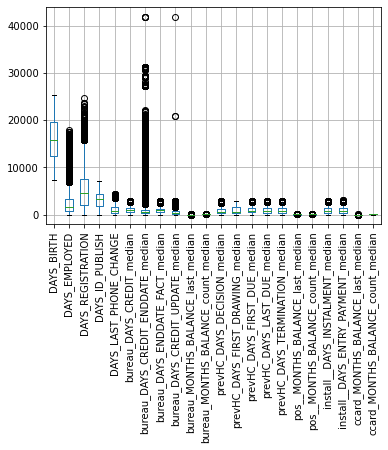

In [58]:
# _ = data[cols_days].hist(figsize=(20,10))
data[cols_days].boxplot()
plt.xticks(rotation=90);

In [62]:
# categorical varibales with different classes between train and test
cols = dict_df['train'].select_dtypes('object').nunique()[dict_df['train'].select_dtypes('object').nunique() - dict_df['test'].select_dtypes('object').nunique() > 0].index
display(dict_df['train'].select_dtypes('object').nunique() - dict_df['test'].select_dtypes('object').nunique()[dict_df['train'].select_dtypes('object').nunique() - dict_df['test'].select_dtypes('object').nunique() > 0])
print('')

for c in cols:
    c_train = set(dict_df['train'][c].unique())
    c_test = set(dict_df['test'][c].unique())
    diff = c_train - c_test
    print(c, diff)

CODE_GENDER                   1.0
EMERGENCYSTATE_MODE           NaN
FLAG_OWN_CAR                  NaN
FLAG_OWN_REALTY               NaN
FONDKAPREMONT_MODE            NaN
HOUSETYPE_MODE                NaN
NAME_CONTRACT_TYPE            NaN
NAME_EDUCATION_TYPE           NaN
NAME_FAMILY_STATUS            1.0
NAME_HOUSING_TYPE             NaN
NAME_INCOME_TYPE              1.0
NAME_TYPE_SUITE               NaN
OCCUPATION_TYPE               NaN
ORGANIZATION_TYPE             NaN
WALLSMATERIAL_MODE            NaN
WEEKDAY_APPR_PROCESS_START    NaN
dtype: float64


CODE_GENDER {'XNA'}
NAME_INCOME_TYPE {'Maternity leave'}
NAME_FAMILY_STATUS {'Unknown'}


In [63]:
## Align these values (replace them in df_train by nan) - to then impute or drop 

# df_train['CODE_GENDER'] = df_train['CODE_GENDER'].map(lambda x: x if x != 'XNA' else np.nan)
data['CODE_GENDER'].replace('XNA', np.nan, inplace=True)
data['NAME_INCOME_TYPE'].replace('Maternity leave', np.nan, inplace=True)
data['NAME_FAMILY_STATUS'].replace('Unknown', np.nan, inplace=True)

**Création de variables domaine à partir du dataset principal**
- Montant du prêt par rapport au revenu du client
- Annuités du prêt par rapport au revenu du
- Annuités du prêt par rapport au prêt (Durée du prêt)  
- Temps emploi actuel par rapport à l'âge  

In [64]:
data['CREDIT_INCOME_RATIO'] = data['AMT_CREDIT'] / data['AMT_INCOME_TOTAL']
data['ANNUITY_INCOME_RATIO'] = data['AMT_ANNUITY'] / data['AMT_INCOME_TOTAL']
data['ANNUITY_CREDIT_RATIO'] = data['AMT_ANNUITY'] / data['AMT_CREDIT']
data['DAYS_EMPLOYED_RATIO'] = data['DAYS_EMPLOYED'] / data['DAYS_BIRTH']

In [65]:
data.shape[1], data.dtypes.value_counts()

(371,
 float64    316
 int64       39
 object      16
 dtype: int64)

<a id='feat_select'></a>
### B. Sélection des variables - réduction dimensionnelle

- Suppression des colonnes redondantes/sans intérêt. (ex. AMT_REQ_CREDIT_BUREAU)
- Supprimer colonnes >= 50% valeurs manquates. 
- Supprimer les variables colinéaires (telles que mesurées par le coefficient de corrélation supérieur à 0,9 par ex.). Pour le moment on ne ferait pas de PCA, pour faciliter l'interpretabilité du modèle après.
- Conserver uniquement les variables les plus pertinentes en utilisant les importances des caractéristiques d'un modèle (suppression de celles dont l'importance est nulle).

**Suppression variables avec >50% valuers manquantes**

In [67]:
mis_values = missing_data(data)

320 columns with missing values out of 371


In [68]:
cols_missing =list(mis_values.loc[mis_values['Percentage']>=50].index)
len(cols_missing)

63

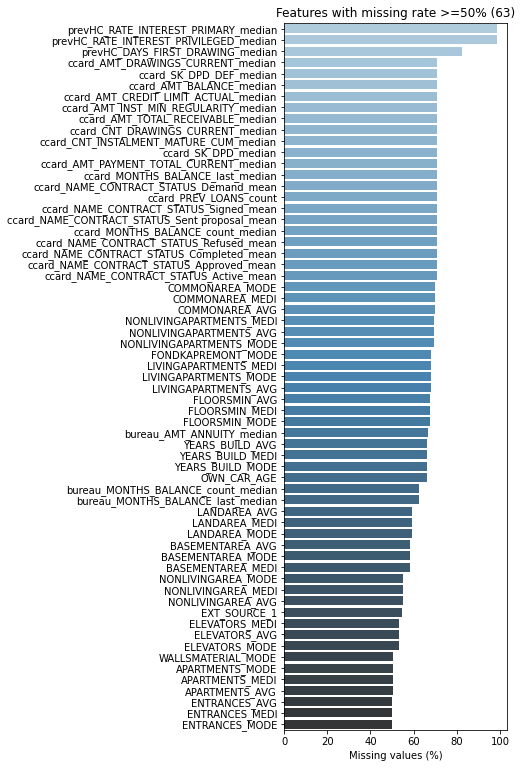

In [69]:
plt.figure(figsize=(4,13))
sns.barplot(y=mis_values.loc[mis_values['Percentage']>=50].index, x=mis_values.loc[mis_values['Percentage']>=50]['Percentage'].values, palette='Blues_d')
_=plt.xlabel('Missing values (%)'), plt.title('Features with missing rate >=50% ({})'.format(len(cols_missing)))

In [70]:
data.drop(columns=cols_missing, inplace=True)
print(data.shape[1])
data.dtypes.value_counts()

308


float64    255
int64       39
object      14
dtype: int64

In [177]:
# Split back train and test and check difference in cols 
train = data.loc[data['SK_ID_CURR'].isin(ID_train)]
test = data.loc[data['SK_ID_CURR'].isin(ID_test)].drop('TARGET', axis=1)
print('Training Data Shape: ', train.shape)
print('Testing Data Shape: ', test.shape)

print('Columns only in train:\n', train.columns.difference(test.columns))
print('Columns only in test:\n', test.columns.difference(train.columns))
# set(train.columns) - set(test.columns) # or with set to make math operations

# Align the dataframes, this will remove the 'TARGET' column  - use this after ohe to check same categories
# df_train, df_test = train.align(test, join = 'inner', axis = 1)

Training Data Shape:  (307511, 308)
Testing Data Shape:  (48744, 307)
Columns only in train:
 Index(['TARGET'], dtype='object')
Columns only in test:
 Index([], dtype='object')


**Analyse varaibles quantitatives - binaires**

In [71]:
# data.describe().loc['std'][data.describe().loc['std'] < .01]
cols_int = data.select_dtypes('int64').columns
cols_float = data.select_dtypes('float64').columns

In [72]:
# binary variables (from int and float)
cols_int = data[cols_int[1:]].nunique()[data[cols_int[1:]].nunique()<3].index  
cols_float = data[cols_float[1:]].nunique()[data[cols_float[1:]].nunique()<3].index  

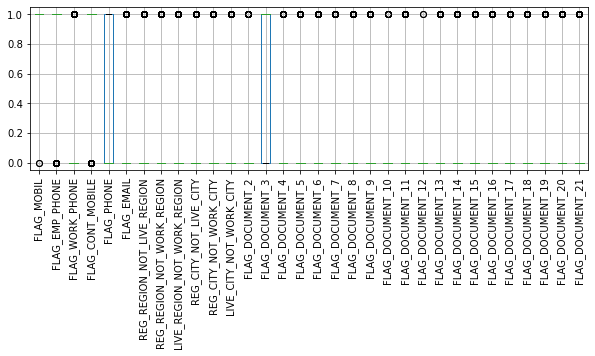

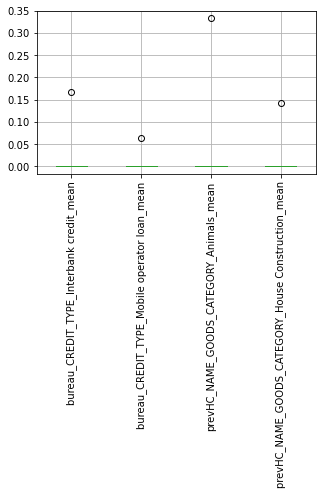

In [73]:
data[cols_int].boxplot(figsize=(10,3))
_=plt.xticks(rotation=90)
plt.show()

data[cols_float].boxplot(figsize=(5,3))
_=plt.xticks(rotation=90)

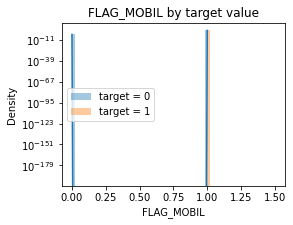

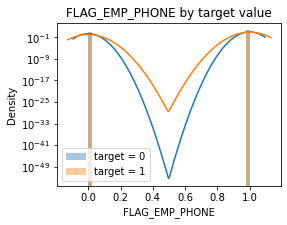

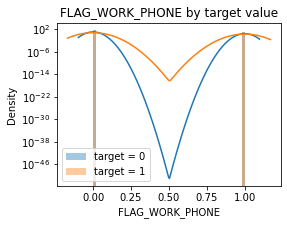

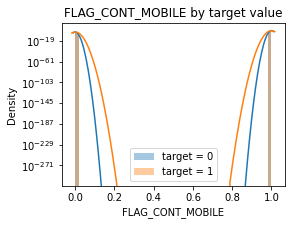

In [74]:
domain_cols = data.columns[-4:]

for var in cols_int[:4]:
    plt.figure(figsize=(4,3))
    sns.distplot(train.loc[train['TARGET'] == 0, var], label = 'target = 0')
    sns.distplot(train.loc[train['TARGET'] == 1, var], label = 'target = 1')
    plt.xlabel(var); plt.ylabel('Density'); plt.title(var +' by target value');
    plt.yscale('log')
    plt.legend()

Ces variables numériques sont binaires et peuvent être considerées comme qualitatives. Pour certains, les proportions des 2 classes du target sont differentes, ce que peut indiquer une possible depandance de celui-ci avec ces variables.

**Analyse variables catégorielles**
> we can fill nan values with category 'missing' or directly use dummy for ohe, so nan values will be zero for all new cols. 

In [75]:
data.select_dtypes('object').isna().sum()/len(data)*100

NAME_CONTRACT_TYPE             0.000000
CODE_GENDER                    0.001123
FLAG_OWN_CAR                   0.000000
FLAG_OWN_REALTY                0.000000
NAME_TYPE_SUITE                0.618377
NAME_INCOME_TYPE               0.001403
NAME_EDUCATION_TYPE            0.000000
NAME_FAMILY_STATUS             0.000561
NAME_HOUSING_TYPE              0.000000
OCCUPATION_TYPE               31.437032
WEEKDAY_APPR_PROCESS_START     0.000000
ORGANIZATION_TYPE              0.000000
HOUSETYPE_MODE                49.940632
EMERGENCYSTATE_MODE           47.147128
dtype: float64

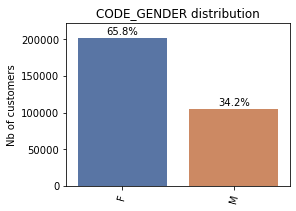

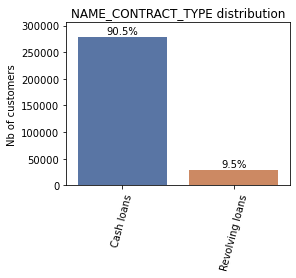

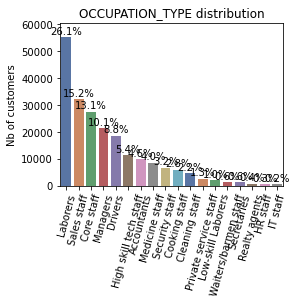

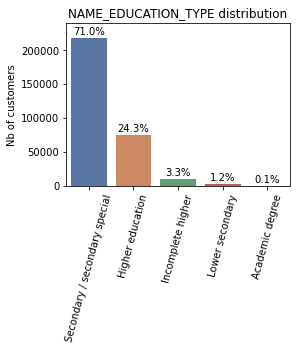

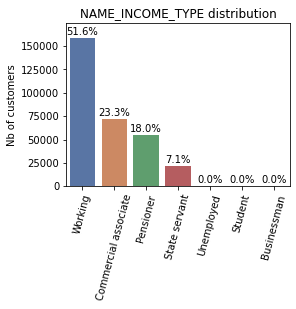

In [157]:
for var in ['CODE_GENDER','NAME_CONTRACT_TYPE','OCCUPATION_TYPE','NAME_EDUCATION_TYPE','NAME_INCOME_TYPE']:
#     plt.figure(figsize=(4,3))
#     sns.countplot(train[var], palette='deep', order=train[var].value_counts().sort_values(ascending=False).index, hue=train.TARGET)
#     plt.yscale('log')
#     _=plt.xticks(rotation=90)

    jobs = train[var].value_counts()

    plt.figure(figsize=(4,3))
    ax=sns.barplot(jobs.index, jobs.values, palette='deep')

    # plt.yscale('log')
    plt.ylabel('Nb of customers')
    plt.xlabel('')
    plt.xticks(rotation=75)
    plt.ylim(0,jobs.values.max()+jobs.values.max()/10)

    for p in ax.patches:
        ax.annotate('{:.1f}%'.format(p.get_height()/jobs.values.sum()*100), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 6),
                    textcoords = 'offset points')

    _=plt.title(var +' distribution')

**Distribution relative du target en fonction des variables catégorielles**

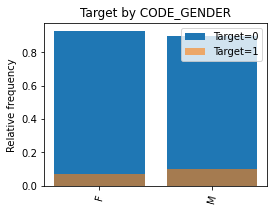

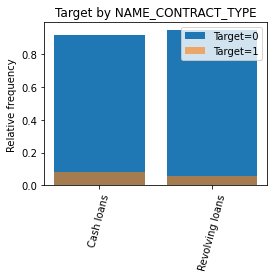

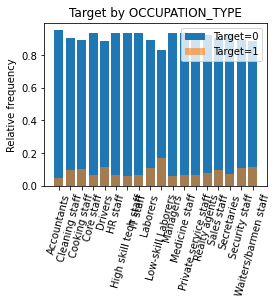

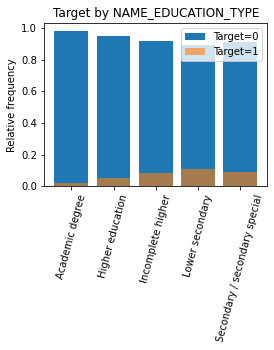

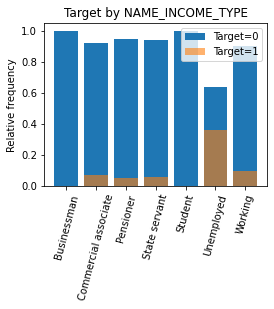

In [155]:
for var in ['CODE_GENDER','NAME_CONTRACT_TYPE','OCCUPATION_TYPE','NAME_EDUCATION_TYPE','NAME_INCOME_TYPE']:
    counts_norm=train.groupby(var)['TARGET'].value_counts(normalize=True).unstack()
    plt.figure(figsize=(4,3))
    plt.bar(counts_norm.index ,counts_norm.iloc[:,0].values, label='Target=0')
    plt.bar(counts_norm.index ,counts_norm.iloc[:,1].values, label='Target=1', alpha=0.6)
    plt.xticks(rotation=75)
    plt.legend()
    plt.title('Target by '+var)
    plt.ylabel('Relative frequency')

Il semble y avoir une dépendance du target avec le type de métier, niveau d'études et type de revenu. On observe une proportion de clients en défaut plus élevée parmi les classes d'ouvrières, pour niveaux d'études moins avancés (niveau secondaire), et sans revenu d'emploi.

**Variables plus correlées avec le target et entre elles**

In [178]:
# Find correlations with the target 
# train['TARGET']=data[data['TARGET'].notnull()]['TARGET']
correlations = train.corr()['TARGET'].sort_values(ascending=False)
print('Most Positive and negative correlations:\n', correlations[np.abs(correlations).sort_values(ascending=False)[:15].index])

Most Positive and negative correlations:
 TARGET                                       1.000000
EXT_SOURCE_3                                -0.178919
EXT_SOURCE_2                                -0.160472
bureau_DAYS_CREDIT_median                   -0.085414
bureau_CREDIT_ACTIVE_Closed_mean            -0.079369
DAYS_BIRTH                                  -0.078239
prevHC_NAME_CONTRACT_STATUS_Refused_mean     0.077671
bureau_CREDIT_ACTIVE_Active_mean             0.077356
DAYS_EMPLOYED                               -0.074958
prevHC_CODE_REJECT_REASON_XAP_mean          -0.073930
DAYS_EMPLOYED_RATIO                         -0.067955
bureau_DAYS_CREDIT_UPDATE_median            -0.067339
prevHC_NAME_CONTRACT_STATUS_Approved_mean   -0.063521
REGION_RATING_CLIENT_W_CITY                  0.060893
REGION_RATING_CLIENT                         0.058899
Name: TARGET, dtype: float64


In [179]:
high_corr_cols_target = correlations[np.abs(correlations).sort_values(ascending=False)[:10].index].index

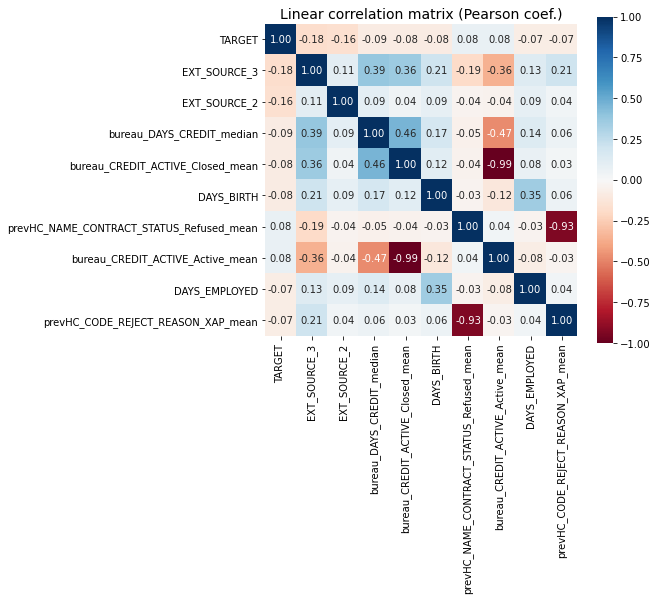

In [180]:
#Correlations variables numeriques
plt.figure(figsize=(7,6))
sns.heatmap(train[high_corr_cols_target].corr(), cmap='RdBu', center=0, vmin=-1, vmax=1, annot=True, fmt='.2f', square=True) 
_=plt.title('Linear correlation matrix (Pearson coef.)', fontsize=14)

- Très faibles correlations avec le _target_. Les 2 `EXT_SOURCE` sont les plus correlées (négativemet) avec le _target_, inidiquant qu'à mesure que leur valeur augmente, le client est plus susceptible de ne pas être en défaut et rembourser le prêt (target=0). Tout comme `DAYS EMPLOYED` et `DAYS_BIRTH`, en moindre mesure.
- Correlations fortes entre quelques varibale, comme les frequences relatives des prêts actives et fermés (négativement correlées). On pourrait supprimer ces variables fortement correlées entre elles (> abs(0.9)). 
- Nous pouvons également observer que `EXT_SOURCE_3` est positivement corrélé avec certains varaibles des prêts anterieurs comme `bureau_DAYS_CREDIT_median`, ce que peut indiquer que ce sont peut-être des facteurs prise en compte pour ce score exterieur.
- Ci-dessous, on peut visualiser les distributions de ces varaibles par valeur du target. Cependant, du au desiquilibre de la distribution du target, il vaut mieux normaliser les distributions pour observer des dépendances possibles avec le target.

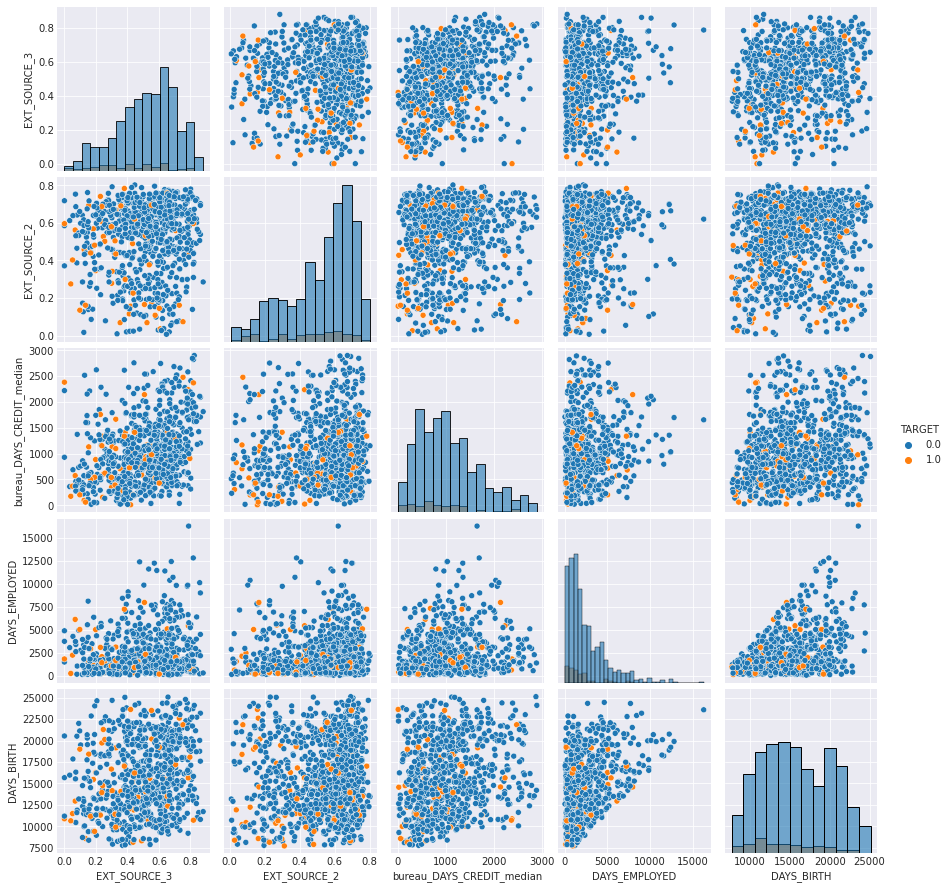

In [181]:
#distribution of each of these features by target to visualise
with plt.style.context('seaborn-darkgrid'):
    g=sns.pairplot(train.sample(1000), vars=['EXT_SOURCE_3', 'EXT_SOURCE_2', 'bureau_DAYS_CREDIT_median','DAYS_EMPLOYED', 'DAYS_BIRTH'], hue='TARGET',
                   diag_kind='hist', diag_kws={'alpha': 0.6})

In [182]:
# variables highly correlated - to drop
col_corr = set() 
corr_matrix = train.drop(['TARGET','SK_ID_CURR'], axis=1).corr().abs()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if (corr_matrix.iloc[i, j] >= 0.9) and (corr_matrix.columns[j] not in col_corr):
            colname = corr_matrix.columns[i] # getting the name of column
            col_corr.add(colname)
len(col_corr)

31

Comme certains de ces variables peuvent être importantes pour des algo type arbres de decision, dans un 1er test on ne va pas enlever les + correlées. Mais les supprimer pourrait ameliorer le modèle de regression log. par ex. ..., à tester.

In [189]:
data_merged_smaller = data.drop(col_corr, axis=1)
data_merged_smaller.shape

(356255, 277)

In [67]:
data.to_csv('data/output/data_merged_withNan.csv', index= False) # but only nan <50% and no further reduction/selection

<a id='model'></a>
## 4. Modélisation

**Pretraitement - transformations (ohe, scaling)  et imputation nan**
- Pour une baseline, les variables qualitatives seront passées à binaires (ohe)- sans avoir besoin de traiter leurs valeurs nan. Les valeurs nan restantes (vars numeriques) seront imputées avec leur mediane et toutes les variables seront normalisées par sont (min et max).
- Des prétraitements plus adaptés pourront être testés avec plus de temps (ex. inputation par mode de catégories, mieux traitement de varaibales binaires, etc.), ce qui pourrait améliorer les performances des modèles.

In [224]:
##--- Takes a lot of time due to mode imputation in categorical !!---##
# Pre-processing for LogisticReg
# X = data.copy()
# X.drop(['SK_ID_CURR','TARGET'], axis=1, inplace=True)

# numerical_features = X.columns[X.dtypes != 'O']
# categorical_features = X.columns[X.dtypes == 'O']

# # transformations
# numerical_pipeline = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='median'), StandardScaler()) #MinMaxScaler()
# categorical_pipeline = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='most_frequent'), OneHotEncoder(sparse=True))
# categorical_pipeline = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='missing'), OneHotEncoder(sparse=True))

# composite_transformer = make_column_transformer((numerical_pipeline, numerical_features), (categorical_pipeline, categorical_features), remainder='passthrough')

# # X_transformed = composite_transformer.fit_transform(X)

In [3]:
## reaload the cleaned data if start from here:
if 'data' in locals():
    print('data already exists')
else:
    print('Reloading cleaned-merged data')
    data = pd.read_csv('data/output/data_merged_withNan.csv')

Reloading cleaned-merged data


In [4]:
# dummy for ohe, so nan in categories will be 0 in all generated cols, instead of having another col
data = pd.get_dummies(data)  
data.shape[1], data.dtypes.value_counts()

(420,
 float64    257
 uint8      126
 int64       37
 dtype: int64)

In [4]:
# to avoid error 'special JSON characters' when running lightgbm due to '\ :' etc. in some columns (after dummy or when reload?)
import re
data = data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

# def urlify(s):

#     # Remove all non-word characters (everything except numbers and letters)
#     s = re.sub(r"[^\w\s]", '', s)

#     # Replace all runs of whitespace with a single dash
#     s = re.sub(r"\s+", '-', s)

#     return s

In [195]:
# data.columns.tolist()

In [5]:
y_labels = data[data['TARGET'].notnull()]['TARGET']
df_train = data[data['TARGET'].notnull()].drop(['SK_ID_CURR','TARGET'], axis=1)
df_test = data[data['TARGET'].isnull()].drop(['TARGET'], axis=1) #only used with final model to make predictions
feature_names = list(df_train.columns)

# split train and test set from df_train to save a test set for final evaluation
X_train, X_test, y_train, y_test = train_test_split(df_train, y_labels, test_size=0.3, random_state=5) 
print('Training set: ', X_train.shape, 'Testing eval set: ', X_test.shape)
print('Training target:', y_train.shape, 'Testing eval target:', y_test.shape)
print('Predicting test set:', df_test.shape)

del data, df_train
gc.collect()

Training set:  (215257, 418) Testing eval set:  (92254, 418)
Training target: (215257,) Testing eval target: (92254,)
Predicting test set: (48744, 419)


22

<a id='reg'></a>
### A. Régression logistique binomial - baseline

In [203]:
from sklearn import set_config

In [204]:
#preprocess and model pipeline 
model_lr = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='median'), MinMaxScaler(), LogisticRegression()) 
set_config(display='diagram') # set_config(display='text')
model_lr

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('minmaxscaler', MinMaxScaler()),
                ('logisticregression', LogisticRegression())])

In [205]:
with timer("Logistic regression with gridsearch cross_val stratified"):
    params_lr = {'logisticregression__C' : [0.001, 0.005 ,0.01, 0.05, 0.1, 0.2]} 
    grid_lr = GridSearchCV(model_lr, param_grid=params_lr, cv=5, return_train_score=True, scoring='roc_auc')  # validation croisée pour trouver les meilleurs paramètres  
    grid_lr.fit(X_train , y_train)
    y_pred = grid_lr.predict_proba(X_test)[:, 1]  

lr_auc_test = roc_auc_score(y_test, y_pred)
print('roc_auc test_set = {:.3f}'.format(lr_auc_test))
grid_lr.best_params_, grid_lr.best_score_ #grid_lr.best_estimator

Logistic regression with gridsearch cross_val stratified - done in 880s
roc_auc test_set = 0.757


({'logisticregression__C': 0.2}, 0.7562133595867944)

In [206]:
# df to save scores for models comparison
y_pred_labels = grid_lr.predict(X_test)
scores = pd.DataFrame(index = ['LogisticRegression','RadomForest','H-GBM'], data={'roc-auc_train': grid_lr.cv_results_['mean_train_score'][1],
                                                                                     'roc-auc_val': grid_lr.best_score_,  
                                                                                     'roc-auc_test': lr_auc_test,
                                                                                    'fbeta_test': fbeta_score(y_test, y_pred_labels, beta=2)})

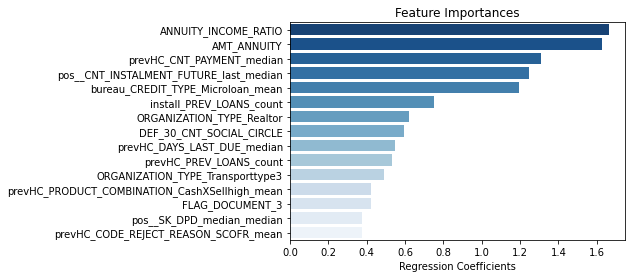

In [207]:
# Extract feature importances
feature_importance_values = grid_lr.best_estimator_.named_steps['logisticregression'].coef_
feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values[0]})
feature_importances_sorted=feature_importances.sort_values(ascending=False, by='importance')
sns.barplot(y=feature_importances_sorted['feature'][:15],x=feature_importances_sorted['importance'][:15], palette='Blues_r')
plt.ylabel(''); plt.xlabel('Regression Coefficients'); plt.title('Feature Importances');

<a id='rf'></a>
### B. Random Forest

In [208]:
model_rf = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='median'), MinMaxScaler(), RandomForestClassifier()) 
# RandomForestClassifier().get_params().keys()

with timer("Random forest with gridsearch cross_val stratified"):
    params_rf = {'randomforestclassifier__n_estimators' : [100,200], 'randomforestclassifier__n_jobs' : [-1]} 
    grid_rf = GridSearchCV(model_rf, param_grid=params_rf, cv=5, return_train_score=True, scoring='roc_auc')  # validation croisée pour trouver les meilleurs paramètres  
    grid_rf.fit(X_train , y_train)
    y_pred = grid_rf.predict_proba(X_test)[:, 1]   

rf_auc_test = roc_auc_score(y_test, y_pred)
print('roc_auc test_set = {:.3f}'.format(rf_auc_test))
grid_rf.best_params_, grid_rf.best_score_ #grid_lr.best_estimator

Random forest with gridsearch cross_val stratified - done in 1671s
roc_auc test_set = 0.720


({'randomforestclassifier__n_estimators': 200,
  'randomforestclassifier__n_jobs': -1},
 0.7209477291633857)

In [209]:
y_pred_labels = grid_rf.predict(X_test)
scores.iloc[1] = [grid_rf.cv_results_['mean_train_score'][1], grid_rf.best_score_, rf_auc_test, fbeta_score(y_test, y_pred_labels, beta=2)]
scores[:-1]

,roc-auc_train,roc-auc_val,roc-auc_test,fbeta_test
LogisticRegression,0.751729,0.756213,0.756861,0.023619
RadomForest,1.000000,0.720948,0.719665,0.000686


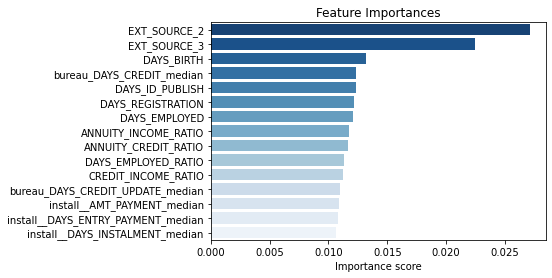

In [210]:
# Extract feature importances
feature_importance_values = grid_rf.best_estimator_.named_steps['randomforestclassifier'].feature_importances_
feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
feature_importances_sorted=feature_importances.sort_values(ascending=False, by='importance')
sns.barplot(y=feature_importances_sorted['feature'][:15],x=feature_importances_sorted['importance'][:15], palette='Blues_r')
plt.ylabel(''); plt.xlabel('Importance score'); plt.title('Feature Importances');

<a id='gbm'></a>
### C. Gradient Boosting
- On comparera 2 implementations d'un _Histogram-Based Gradient Boosting_, celle de la bibliothèque sklearn (inspirée de lighGBM) et celle de LightGBM . Plus sur differents algorithmes de GB, [ici](https://machinelearningmastery.com/gradient-boosting-with-scikit-learn-xgboost-lightgbm-and-catboost/).
- Ce type de modèles de GB permettent de gerer les valeurs nan, on testera donc avec nan et sans nan (imputées). 

In [211]:
## Implementation from sklearn
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

In [212]:
# model_gb = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='median'), MinMaxScaler(),HistGradientBoostingClassifier()) 
model_gb = make_pipeline(HistGradientBoostingClassifier()) 

with timer("GB with gridsearch stratified cross_val"):
    params_gb = {'histgradientboostingclassifier__learning_rate' : [0.02, 0.05],  #[0.02, 0.05]
                 'histgradientboostingclassifier__random_state' : [5]} 
    grid_gb = GridSearchCV(model_gb, param_grid=params_gb, cv=5, return_train_score=True, scoring='roc_auc')  # validation croisée pour trouver les meilleurs paramètres  
    grid_gb.fit(X_train , y_train)
    y_pred = grid_gb.predict_proba(X_test)[:, 1]   

gb_auc_test = roc_auc_score(y_test, y_pred)
print('roc_auc test_set = {:.3f}'.format(gb_auc_test))
grid_gb.best_params_, grid_gb.best_score_ #grid_lr.best_estimator

GB with gridsearch stratified cross_val - done in 678s
roc_auc test_set = 0.764


({'histgradientboostingclassifier__learning_rate': 0.05,
  'histgradientboostingclassifier__random_state': 5},
 0.7628157068992926)

In [213]:
y_pred_labels = grid_gb.predict(X_test)
scores.iloc[2] = [grid_gb.cv_results_['mean_train_score'][1], grid_gb.best_score_, gb_auc_test, fbeta_score(y_test, y_pred_labels, beta=2)]

#### LGBM avec même hyperparamètres trouvés pour H-GBM 

In [214]:
def model_lgbm(X_train, y_train, X_test, y_test, n_folds = 5):
    
    # Empty arrays for out of fold validation and test predictions
    oof_preds = np.zeros(X_train.shape[0])
    test_preds = np.zeros(X_test.shape[0])
    
    # Empty array for feature importances
    feature_names = X_train.columns
    feature_importance_values = np.zeros(len(feature_names))
    
     # Create the kfold object for model cross validation 
    k_fold = StratifiedKFold(n_splits = n_folds, shuffle = True, random_state = 50)   
    
    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []
    
    # Iterate through each fold
    for n_fold, (train_idx, valid_idx) in enumerate(k_fold.split(X_train, y_train)):
        # Training data for the fold
        train_features, train_labels = X_train.iloc[train_idx], y_train.iloc[train_idx]
        # Validation data for the fold
        valid_features, valid_labels = X_train.iloc[valid_idx], y_train.iloc[valid_idx]
           
        # Create the model
        model = LGBMClassifier(n_estimators=10000, objective = 'binary', 
                               class_weight = 'balanced', learning_rate = 0.05, 
                               reg_alpha = 0.1, reg_lambda = 0.1, 
                               subsample = 0.8, n_jobs = -1, random_state = 50)
        
#         # LightGBM parameters found by Bayesian optimization
#         model = LGBMClassifier(
#             nthread=4,
#             n_estimators=10000,
#             learning_rate=0.02,
#             num_leaves=34,
#             colsample_bytree=0.9497036,
#             subsample=0.8715623,
#             max_depth=8,
#             reg_alpha=0.041545473,
#             reg_lambda=0.0735294,
#             min_split_gain=0.0222415,
#             min_child_weight=39.3259775)
        
        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                        eval_names = ['valid', 'train'], categorical_feature = 'auto',
                        early_stopping_rounds = 100, verbose = 200)
        
        
        # Record the out of fold predictions
        oof_preds[valid_idx] = model.predict_proba(valid_features, num_iteration = model.best_iteration_)[:, 1]
        # Make predictions in test
        test_preds += model.predict_proba(X_test, num_iteration = model.best_iteration_)[:, 1] / k_fold.n_splits
        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']      
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        # Clean up memory
        gc.enable()
        del train_features, valid_features
        gc.collect()
        
    
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation and test score
    valid_auc = roc_auc_score(y_train, oof_preds)
    test_auc = roc_auc_score(y_test, test_preds)
    
    # Add the overall mean scores 
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    return model, test_auc, feature_importances, metrics

In [215]:
with timer("Run LightGBM with stratified cross valid"):
    model, test_auc, feature_importances, metrics = model_lgbm(X_train, y_train, X_test, y_test)

Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.832781	train's binary_logloss: 0.515658	valid's auc: 0.770534	valid's binary_logloss: 0.541989
Early stopping, best iteration is:
[233]	train's auc: 0.841262	train's binary_logloss: 0.506781	valid's auc: 0.771193	valid's binary_logloss: 0.536304
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.832368	train's binary_logloss: 0.515986	valid's auc: 0.770546	valid's binary_logloss: 0.538141
[400]	train's auc: 0.875284	train's binary_logloss: 0.469597	valid's auc: 0.77026	valid's binary_logloss: 0.508737
Early stopping, best iteration is:
[310]	train's auc: 0.857899	train's binary_logloss: 0.488944	valid's auc: 0.771153	valid's binary_logloss: 0.520846
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.833524	train's binary_logloss: 0.514591	valid's auc: 0.764206	valid's binary_logloss: 0.540528
Early stopping, best iteration is:
[219]	train's 

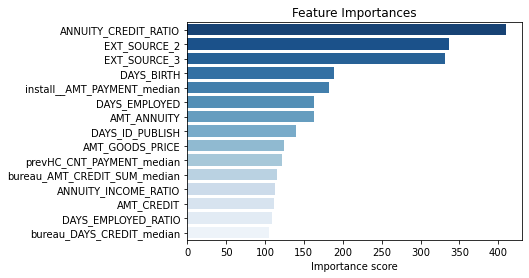

In [216]:
feature_importances_sorted=feature_importances.sort_values(ascending=False, by='importance')
sns.barplot(y=feature_importances_sorted['feature'][:15],x=feature_importances_sorted['importance'][:15], palette='Blues_r')
plt.ylabel(''); plt.xlabel('Importance score'); plt.title('Feature Importances');

In [217]:
## Refit LightGBM on X_train without cross val
clf = LGBMClassifier(n_estimators=10000, objective = 'binary', 
                               class_weight = 'balanced', learning_rate = 0.05, 
                               reg_alpha = 0.1, reg_lambda = 0.1, 
                               subsample = 0.8, n_jobs = -1, random_state = 50)

t0 = time.time()
clf.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)
lgbm_time = time.time() - t0

Training until validation scores don't improve for 200 rounds
[200]	valid_0's auc: 0.771055	valid_0's binary_logloss: 0.544767
[400]	valid_0's auc: 0.772284	valid_0's binary_logloss: 0.518803
Early stopping, best iteration is:
[309]	valid_0's auc: 0.772775	valid_0's binary_logloss: 0.529292


In [218]:
# should be the same as before for model
roc_auc_score(y_test, clf.predict_proba(X_test)[:,1]), fbeta_score(y_test, clf.predict(X_test), beta=2)

(0.7727746570726433, 0.4322098846846204)

In [219]:
lgbm_metrics = pd.DataFrame(np.array([metrics.iloc[-1][1], metrics.iloc[-1][2], test_auc, fbeta_score(y_test, model.predict(X_test), beta=2)]).reshape(1,4), 
                            columns=scores.columns).set_axis(['LGBM'],axis=0)
scores = scores.append(lgbm_metrics)

In [220]:
# add fitting times for comparison
times = pd.DataFrame(index=scores.index , data={'refit_time':[grid_lr.refit_time_, grid_rf.refit_time_, grid_gb.refit_time_, lgbm_time]})
scores = scores.merge(times, left_index=True, right_index=True, how='outer')
scores = scores.round(3)
scores

,roc-auc_train,roc-auc_val,roc-auc_test,fbeta_test,refit_time
LogisticRegression,0.752,0.756,0.757,0.024,30.867
RadomForest,1.000,0.721,0.720,0.001,214.878
H-GBM,0.801,0.763,0.764,0.018,69.046
LGBM,0.848,0.770,0.773,0.430,69.859


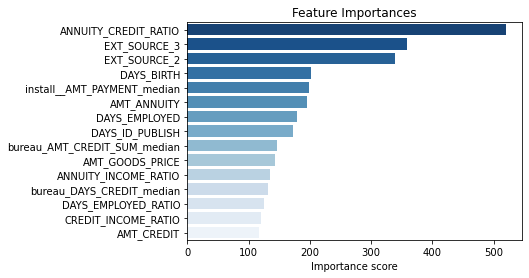

In [221]:
# Extract feature importances
feature_importance_values = clf.feature_importances_
feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
feature_importances_sorted=feature_importances.sort_values(ascending=False, by='importance')
sns.barplot(y=feature_importances_sorted['feature'][:15],x=feature_importances_sorted['importance'][:15], palette='Blues_r')
plt.ylabel(''); plt.xlabel('Importance score'); plt.title('Feature Importances');

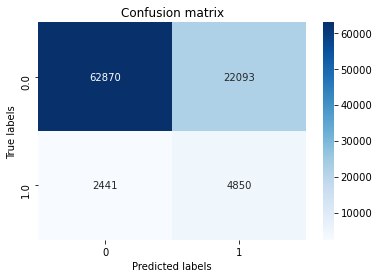

In [222]:
df_conf_matrix = pd.DataFrame(confusion_matrix(y_test, clf.predict(X_test)), index = y_test.unique())
sns.heatmap(pd.DataFrame(df_conf_matrix), annot=True, cmap="Blues", fmt='.0f')
plt.title('Confusion matrix'), plt.xlabel('Predicted labels'), plt.ylabel('True labels');

In [223]:
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.96      0.74      0.84     84963
         1.0       0.18      0.67      0.28      7291

    accuracy                           0.73     92254
   macro avg       0.57      0.70      0.56     92254
weighted avg       0.90      0.73      0.79     92254



In [234]:
#save model and test data to predict in api

df_test['TARGET'] = clf.predict_proba(df_test.iloc[:,1:], num_iteration=model.best_iteration_)[:,1]
df_test['RISK_label'] = df_test['TARGET'].apply(lambda x: 'high' if x > 0.5 else 'low')

df_test[['SK_ID_CURR', 'TARGET', 'RISK_label']].to_csv('data/output/lgbm_predictions.csv', index=False)
df_test.to_csv('data/output/df_test_predicted.csv', index=False)

import pickle
filename = 'data/output/lgbm_model.sav'
pickle.dump(clf, open(filename, 'wb'))

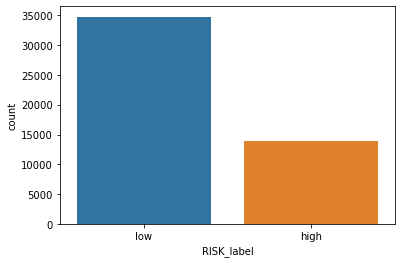

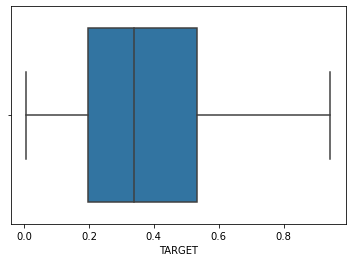

In [235]:
sns.countplot(df_test['RISK_label']);
plt.show()
sns.boxplot(df_test['TARGET']);

<a id='interp'></a>
## 5. Interprétabilité du modèle

In [6]:
import shap
import pickle

In [2]:
## if not in memory, reload
# df_test=pd.read_csv('data/output/df_test_predicted.csv')
# clf = pickle.load(open('data/output/lgbm_model.sav', 'rb')) 

In [8]:
# Create object to compute shap values to explain model output (can be probability but not supported for lgbm - so we use raw outpu (log-odds : used as cost function in lgbm))
explainer = shap.TreeExplainer(clf, model_output='raw')  # model_output='predict_proba' not supported 

# Calculate Shap values
shap_values_train = explainer.shap_values(X_train)[1]
# pickle.dump(shap_values, open('data/output/shap_values_X_train.sav', 'wb'))
shap_values_test = explainer.shap_values(df_test.iloc[:,1:-2])[1] # return a list with two arrays: 1st is negative class, 2nd for positive class
shap_values_test.shape

(48744, 418)

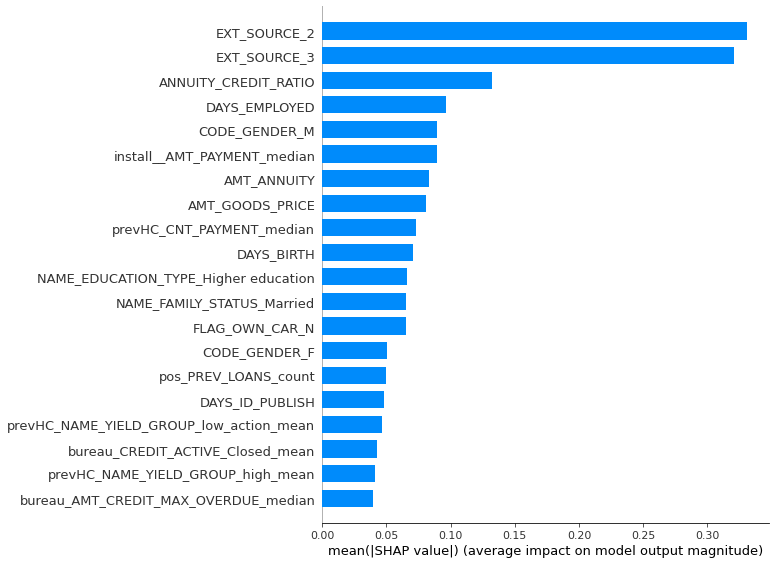

In [18]:
shap.summary_plot(shap_values_train, X_train, plot_type="bar") #only default class
# shap.summary_plot(shap_values_test,  df_test.iloc[:,1:-2], plot_type="bar") #only default class

Text(0.5, 1.0, 'Impact of feature values in terms of SHAP')

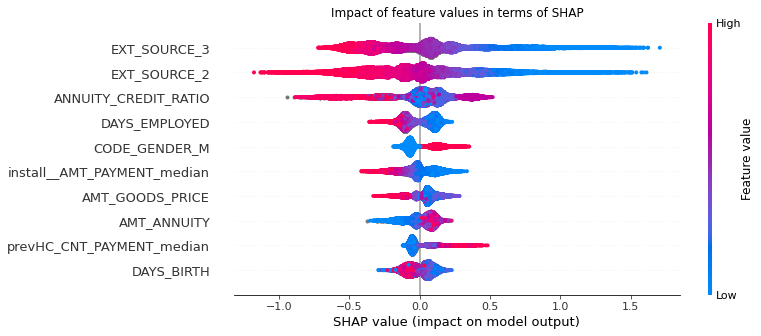

In [10]:
## summarize the effects of all the features 

# for only first 1000 clients
# shap.summary_plot(shap_values[0:1000,:], df_test.iloc[0:1000,1:-2].values, feature_names=df_test.iloc[:,1:-2].columns, max_display=10, show=False)

shap.summary_plot(shap_values_test, # shap values
                  df_test.iloc[:,1:-2].values, # data (np.array)
                  feature_names=df_test.iloc[:,1:-2].columns, 
                  max_display=10, # nb of displayed features
                  show=False, 
                 ) 
# Change size of the figure
plt.gcf().set_size_inches((10,5))
plt.title('Impact of feature values in terms of SHAP')
# plt.savefig('data/output/shap_summary_plot.png',bbox_inches ="tight", dpi=300)

In [12]:
# # compute expected value (mean of predictions on training set = model base output) - to be calculated after shap values
expected_value = explainer.expected_value[1]
print(expected_value)
#Importing the inverse of the logit function (expit(x) = 1/(1+exp(-x))) for the base value transformation
from scipy.special import expit 
print(expit(expected_value))

-0.5837174068241462
0.35807766771567334


**Conversion des valuers shapley pour avoir probabilités au lieu de log-odds**

In [13]:
def shap_transform_scale(shap_values, expected_value, model_prediction):
    #applying the inverse logit to the base value to have probab instead of log-odds   
    expected_value_transformed = expit(expected_value)
    # distance in log-odds space
    original_explanation_distance = np.sum(shap_values)
    #distance in probability space
    distance_to_explain = model_prediction - expected_value_transformed
    #distance_coefficient (ratio between both distances) to then convert
    distance_coefficient = original_explanation_distance / distance_to_explain
    #Transforming the original shapley values to probab space
    shap_values_transformed = shap_values / distance_coefficient
    
    return shap_values_transformed, expected_value_transformed 

shap values sum:  0.007359436182476076 Prediction - model base:  0.007359436182476031


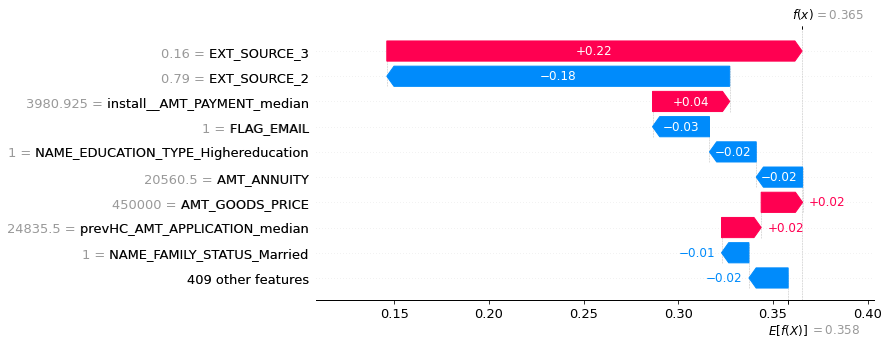

In [30]:
# local explanation for 1st customer - how we get from base output to individual's model prediction

shap_values_trans, expected_value_trans = shap_transform_scale(shap_values_test[0], 
                                                               expected_value=explainer.expected_value[1], 
                                                               model_prediction=df_test.iloc[0]['TARGET'])

# sum all features contribution (shapley valeus) = difference between this prediction and the model's base output (mean of preditions over train set)
print('shap values sum: ',shap_values_trans.sum(), 'Prediction - model base: ', df_test.iloc[0]['TARGET'] - expected_value_trans)

shap.plots._waterfall.waterfall_legacy(expected_value_trans, shap_values_trans,
                                       df_test.iloc[:,1:-2].values.reshape(-1),
                                       feature_names=df_test.iloc[:,1:-2].columns,
                                       max_display=10, show=False)

plt.gcf().set_size_inches((10,5))
# plt.savefig('data/output/local_shap_plot.png', bbox_inches ='tight', dpi=300)

In [31]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values_test[0], df_test.iloc[:,1:-2].columns)

In [32]:
# save df main features according to shap values test set and their descriptions fo app_dash
feature_names=sorted(['EXT_SOURCE_3', 'EXT_SOURCE_2','ANNUITY_CREDIT_RATIO','CODE_GENDER_M','DAYS_EMPLOYED', 'install__AMT_PAYMENT_median', 'AMT_GOODS_PRICE', 'AMT_ANNUITY','DAYS_BIRTH'])
descriptions = ['Loan annuity', 
                'For consumer loans it is the price of the goods for which the loan is given', 
                'Ratio between loan annuity and credit amount (annuity relative to credit)', 
                'Binary variable: 1 if customer\'s gender is Male, 0 otherwise',
                'Client\'s age in days at the time of application',
                'How many days before the application the person started current employment',
                'Normalized score from external data source',
                'Normalized score from external data source',
                'Median of all installments amount actually paid by the client on previous credit']
main_features = pd.DataFrame(data={'Features':feature_names,'Description':descriptions})
main_features.to_csv('data/output/main_features.csv', index=False)

**Calcul des plus proches voisins pour statistiques des 20 clients similaires au client analysé**

In [273]:
from sklearn.neighbors import NearestNeighbors

In [304]:
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
X_train_nn = imputer.fit_transform(X_train)
X_test_nn = imputer.transform(df_test.iloc[:,1:-2])

In [308]:
X_cust = pd.DataFrame(X_test_nn).sample(1)
customer_idx = X_cust.index.values[0]

In [309]:
clf.predict_proba(X_cust)[:,1][0]

0.3212284006788188

In [310]:
# train nearest neighbors in the test set since i'll not have idx of train after
nn = NearestNeighbors(n_neighbors=20)
nn.fit(X_test_nn) 

NearestNeighbors(n_neighbors=20)

In [312]:
# get indices of the 20 nearest neighbors in the test df
nearest_idx = nn.kneighbors(X=X_test_nn[customer_idx].reshape(1, -1),n_neighbors=20,return_distance=False).ravel()

In [314]:
clf.predict_proba(X_test_nn[nearest_idx])[:,1].mean()

0.3748025749467606

In [316]:
df_test_nn = df_test.copy()
df_test_nn.iloc[:,1:-2] = X_test_nn

In [318]:
# save this test set with input values and nneighbors model to use in api
df_test_nn.to_csv('data/output/df_test_predicted_imputed.csv', index=False)
pickle.dump(nn, open('data/output/nneighbors_model.sav', 'wb'))

**Comparaison de la mediane des variables plus importantes entre les 2 classes target vs. 1 client et ses voisins**

In [24]:
df_test_nn.set_index('SK_ID_CURR', inplace=True)

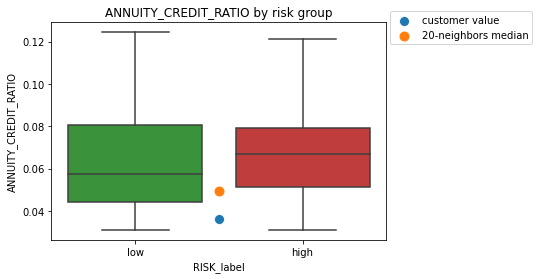

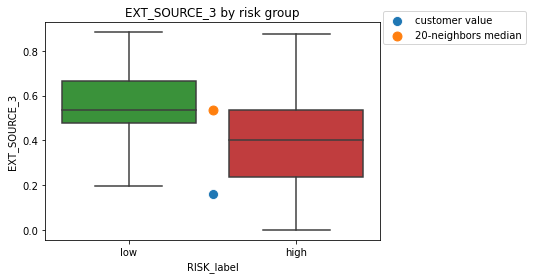

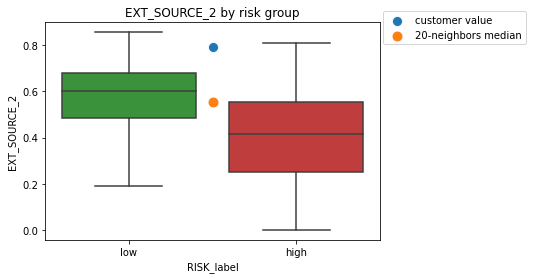

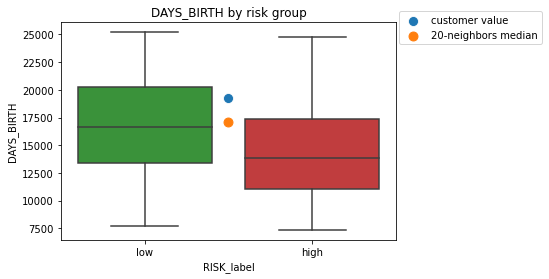

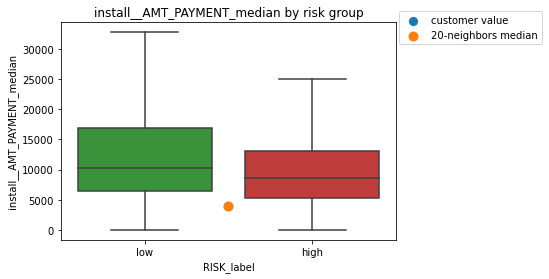

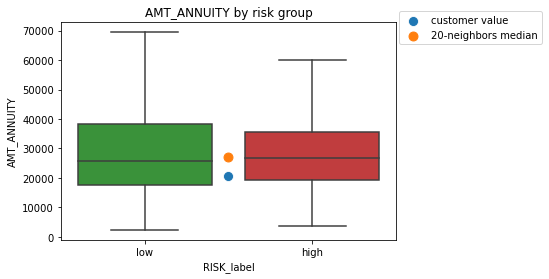

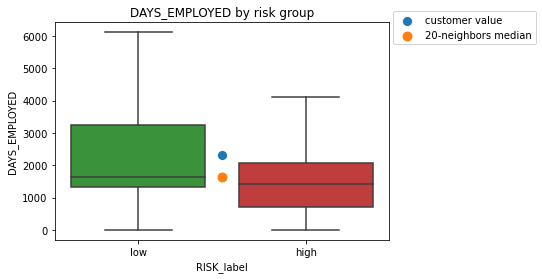

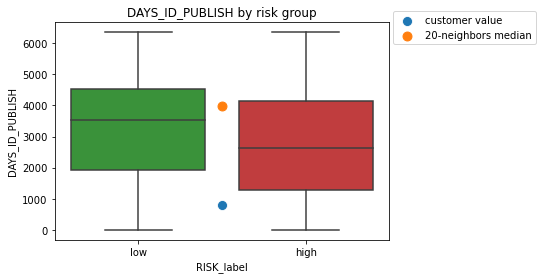

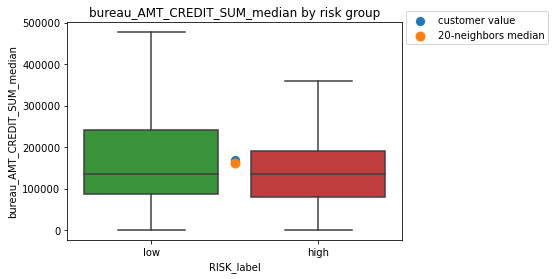

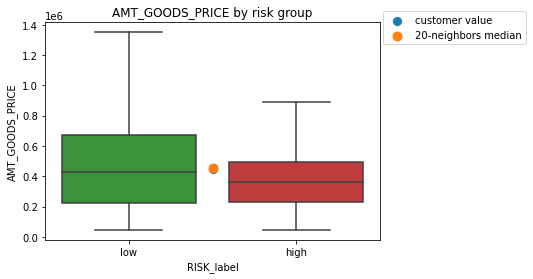

In [319]:
# plot moyennes std ou boxplots pour numeriques
ID=100001 
nearest_idx = nn.kneighbors(X=np.array(df_test_nn.loc[ID].iloc[:-2]).reshape(1, -1),n_neighbors=20,return_distance=False).ravel()
df_neighbors = df_test_nn.iloc[nearest_idx]   

for c in feature_importances_sorted['feature'][:10]:  #main_features.Features
    sns.boxplot(x='RISK_label', y=c ,data=df_test_nn, showfliers=False, palette=[sns.color_palette()[2], sns.color_palette()[3]])
    sns.scatterplot(x=0.5, y=c, data=pd.DataFrame(df_test_nn.loc[ID]).T, s=100, color=sns.color_palette()[0], label=('customer value'))
    sns.scatterplot(x=0.5, y=c, data=pd.DataFrame(df_neighbors.median()).T, s=100, color=sns.color_palette()[1], label=('20-neighbors median'))
    plt.title(c+ ' by risk group')
    plt.legend(loc=(1.01,0.9))
    plt.show() 
    plt.legend(loc=(1.01,0.9))
    
    
# 
# for c in feature_importances_sorted['feature'][:10]:
#     plt.figure(figsize=(5,3))
# #     sns.barplot(x='RISK_label', y=c, ci='sd', data = df_test, alpha=0.7)
#     plt.bar(0, df_test_nn.loc[ID][c], label=('customer'))
#     plt.bar(1, df_neighbors[c].median(), alpha=0.7, label=('20-neighbors'))
#     plt.bar(2, df_test_nn.loc[df_test_nn['RISK_label']=='low', c].median(), label=('all low risk'))
#     plt.bar(3, df_test_nn.loc[df_test_nn['RISK_label']=='low', c].median(), label=('all high risk'))
#     plt.bar(4, df_test_nn[c].median(), label=('all'))

# #     if df_test.loc[df_test['SK_ID_CURR']==ID, 'RISK_label'].values == 'low': pos=0
# #     else: pos=1
# #     sns.scatterplot(x=pos, y=c, data=df_test[df_test['SK_ID_CURR']==ID], s=100, color='r')
#     plt.title('Medians of '+ str(c) + ' by group')
#     plt.legend(loc=(1,0.5))
#     plt.show()

In [320]:
imptt_features = feature_importances_sorted['feature'][:10].values
X_means_extra=df_test.groupby('RISK_label').median()[imptt_features]
X_means_extra = X_means_extra.append(pd.DataFrame(df_test_nn[imptt_features].loc[ID]).T).rename({ID: 'customer'}, axis=0)  
X_means_extra = X_means_extra.append(pd.DataFrame(df_neighbors[imptt_features].median()).T).rename({0: 'neighbors'}, axis=0)
X_means_norm_extra = MinMaxScaler().fit_transform(X_means_extra)
X_means_norm_extra =pd.DataFrame(X_means_norm_extra, columns=imptt_features).set_axis([X_means_extra.index.values], axis=0)
# X_means_norm_extra= X_means_norm_extra.rename({0:'low', 1:'high'}, axis=0)

In [321]:
# digramme de kiviat (polaire)
colors=[sns.color_palette()[3], sns.color_palette()[2], sns.color_palette()[0], sns.color_palette()[1]]#sns.color_palette()[0:7]
# markers = [1,2,3]
# str_markers = ['1','2','3']

def plot_kiviat(df, labels, colors):

    labels = np.array(labels)
    angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False)

    fig= plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, polar=True)
    ax.set_title('Normalized medians of features by group', fontsize='13')
    ax.grid(True)
    ax.set_thetagrids(angles * 180/np.pi, labels)
    
    for i in range(df.shape[0]):
        values=df.iloc[i].values.flatten().tolist()
        ax.plot(angles, values, '-o', linewidth=2, label=df.index[i], color=colors[i])
        ax.fill(angles, values, alpha=0.1, color=colors[i])
   
    #plt.ylim(df.min().min(),3)
    ax.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
   
    return plt.show()

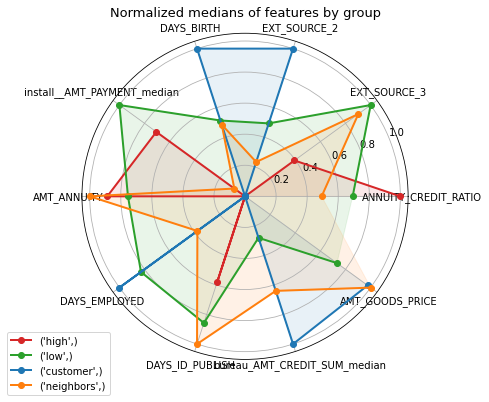

In [322]:
plot_kiviat(X_means_norm_extra, imptt_features, colors) 